# Tests on parts of  NA12878 data for Del_st, Del_end and No_sv, ground  truth Mills_nanosv

We are going to use a network trained on a random subsample of NoSv, and apply it to the whole training set. Then we are going to take the confused NoSvs as training Nosvs to a nother network
The training set is the first 16 chromozomzes, the test is the rest

## Load dependences and setting output configuration

In [1]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
%pylab inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Load data from npy files

In [2]:
import pickle
dico = pickle.load(open("F:/1_GTCG/data/11092018/labels.pickle/labels.pickle", "rb"))
data_labels = dataset = dico["Mills2011_nanosv"]
window_size = 200

In [3]:
dico = []

In [4]:
replications = 16
factor_nosv = 1 

In [ ]:
# after iteration 4 I was taking only the SV windows because of memory problems and because I don't really need all nosv

In [ ]:
datapath = 'F:/1_GTCG/data/TestData_060818.tar/TestData_060818/NA12878' 

germline_1_datapath = datapath + '/ChannelData/unzipped/'
ger_1_labels_datapath = datapath + '/LabelData/unzipped/'

G1_data_SV = np.empty([0, 27, window_size])
G1_labels_SV =[]
G1_data_noSV = np.empty([0, 27, window_size])
G1_labels_noSV =[]
total_train_sv_windows = 0
for i in range(1,16,1):
        G1_data_new =np.load(germline_1_datapath + str(i) + '_channel_maker_real_germline.npy/' + str(i) +'_channel_maker_real_germline.npy')
        #G1_labels_new = np.load(ger_1_labels_datapath  +  str(i) +'_label_ci_full_overlap.npy/' +str(i) +'_label_ci_full_overlap.npy') 
        G1_labels_new = np.array(data_labels[str(i)])
        print(G1_labels_new[0])
        G1_data_new = G1_data_new[np.where(G1_labels_new != 'UK')]
        G1_labels_new = G1_labels_new[np.where(G1_labels_new != 'UK')]
        G1_data_SV_new  = G1_data_new[np.where(G1_labels_new != 'noSV')]
        G1_labels_SV_new  = G1_labels_new[np.where(G1_labels_new != 'noSV')]
        n_windows_sv = G1_data_SV_new.shape[0]
        G1_data_noSV_new  = G1_data_new[np.where(G1_labels_new == 'noSV')]
        G1_labels_noSV_new  = G1_labels_new[np.where(G1_labels_new == 'noSV')]
        #G1_data_noSV_new =  G1_data_noSV_new[0:int(replications*n_windows_sv/2/factor_nosv)]
        #G1_labels_noSV_new =  G1_labels_noSV_new[0:int(replications*n_windows_sv/2/factor_nosv)]
        print(str(i) + ':' + str(G1_data_SV_new.shape))
        #print(G1_labels_SV_new[0])
        G1_data_SV = np.concatenate((G1_data_SV, G1_data_SV_new))
        G1_labels_SV = np.concatenate((G1_labels_SV, G1_labels_SV_new))
        G1_data_noSV = np.concatenate((G1_data_noSV, G1_data_noSV_new))
        G1_labels_noSV = np.concatenate((G1_labels_noSV, G1_labels_noSV_new))
        if i < 16: #for training until chromozome 16
            total_train_sv_windows += G1_data_SV_new.shape[0]

### Find  the indexes that split the categories

In [7]:
def find_splitting_indices(labels):
    for i in range (0, labels.shape[0] - 1):
        if (labels[i] != labels[i+1]):
            print(i , ': ', labels[i] , labels[i+1] )        

In [8]:
#find_splitting_indices(G1_labels)

In [9]:
#G1_labels_SV = ['DEL'] * G1_labels_SV.shape[0]

In [10]:
sv=G1_data_SV.shape[0]

In [11]:
sv

1239

In [12]:
int(sv/2)

619

In [13]:
#G1_data_noSV  = G1_data_noSV[0:2*sv] 

In [14]:
#G1_labels_noSV  = G1_labels_noSV[0:2*sv] 

In [15]:
SV_train =  0 #int(0.8 * total_train_sv_windows)
noSV_train = 0 #int(replications * SV_train / 2/factor_nosv)

SV_val = 0 # total_train_sv_windows - SV_train
noSV_val = 0 # int(replications * SV_val / 2/factor_nosv)

In [16]:
def replicate(data, start, end, howmanytimes): 
    X = data[start:end]
    for i in range(0,howmanytimes):
        X = np.concatenate((X, data[start:end]))
    return X 

In [17]:
replications = 1#no rep for testing
X_train = replicate(G1_data_SV, 0, SV_train, replications)
y_train = replicate(G1_labels_SV, 0, SV_train,replications)
X_val = replicate(G1_data_SV, SV_train, SV_train+SV_val, replications)
y_val = replicate(G1_labels_SV, SV_train, SV_train+SV_val, replications)
X_test = replicate(G1_data_SV, SV_train+SV_val, len(G1_data_SV), replications)
y_test = replicate(G1_labels_SV, SV_train+SV_val, len(G1_labels_SV), replications)

In [19]:
G1_data_noSV.shape

(394504, 27, 200)

In [20]:
G1_data_noSV = G1_data_noSV[0:200000] 

In [21]:
G1_labels_noSV = G1_labels_noSV[0:200000] 

In [22]:
X_train = np.concatenate((X_train, G1_data_noSV[0:noSV_train ]))
X_val = np.concatenate((X_val, G1_data_noSV[noSV_train:noSV_train +noSV_val ]))
X_test = np.concatenate((X_test, G1_data_noSV[noSV_train +noSV_val:]))

In [23]:
G1_data_noSV = []

In [24]:
y_train = np.concatenate((y_train, G1_labels_noSV[0:noSV_train ]))
y_val = np.concatenate((y_val, G1_labels_noSV[noSV_train:noSV_train +noSV_val ]))
y_test = np.concatenate((y_test, G1_labels_noSV[noSV_train +noSV_val:]))

In [25]:
#G1_labels_noSV = []

In [26]:
y_test

array(['DEL_start', 'DEL_end', 'DEL_start', ..., 'noSV', 'noSV', 'noSV'], 
      dtype='<U32')

### Number of training, validation and test windows

In [27]:
X_train.shape

(0, 27, 200)

In [28]:
X_val.shape

(0, 27, 200)

In [29]:
X_test.shape

(202478, 27, 200)

In [30]:
y_test.shape

(202478,)

In [31]:
number_channels = X_train.shape[1]
number_channels

27

## Normalize data using the reads coverage as parameter and remove uninteresting channels for deletions

In [32]:
coverage = np.median(X_test[:, 0, :]) #the median of the coverage in the normal cells
coverage


42.0

In [33]:
def normalize(X):       
    for i in range (0, len(X)):                              
        for j in range(0,number_channels):                                                                                            
            X[i][j] = np.divide(X[i][j], coverage)*100 
normalize(X_train)
normalize(X_val)
normalize(X_test)

In [34]:
def eliminate_noise_chanels(X):
    return np.delete(X, [4-1,5-1,6-1,7-1,8-1,9-1,10-1,12-1,13-1,15-1,16-1, 17-1,18-1,19-1,23-1,24-1,26-1,27-1], axis=1)
    

In [35]:
def eliminate_distance_chanels(X):
    return np.delete(X, [3,4,7,8], axis=1)

In [36]:
X_train = eliminate_noise_chanels(X_train)
X_val = eliminate_noise_chanels(X_val)
X_test = eliminate_noise_chanels(X_test)

In [37]:
X_train = eliminate_distance_chanels(X_train)
X_val = eliminate_distance_chanels(X_val)
X_test = eliminate_distance_chanels(X_test)

In [38]:
X_train.shape

(0, 5, 200)

In [39]:
number_channels = X_train.shape[1]
number_channels

5

## Differentiate the time series for a zero mean

In [40]:
def differentiate(X):
    for i in range(0, X.shape[0]):        
        for j in range(0, X.shape[1]):
            for k in range(0, X.shape[2]-1):
                X[i][j][k] = X[i][j][k+1] - X[i][j][k]
    return X[:,:,:-1]        

In [41]:
#X_train = differentiate(X_train)

In [42]:
#X_val = differentiate(X_val)
#X_test = differentiate(X_test)

## Plots several  windows

In [43]:
n_windows = 100
label = ["None"] * number_channels

In [44]:
label[0] = "germline:coverage"
label[1] = "germline:#left clipped reads"
label[2] = "germline:#right clipped reads"
label[3] = "germline:#split reads right split"
label[4] = "germline:#split reads left split"

In [70]:
from numpy import *
import math
import matplotlib.pyplot as plt

colors =['b','g', 'm', 'gray', 'r','c', 'darkgreen' ,'y', 'k', 'orange', 'gray']

def plot_channels(start_window, n_windows):
    for i in range (start_window, start_window + n_windows, 1):
        if labels[y_test[i]] == labels[predicted[i]]:
            continue
        #print(y_train[i], 'id:', i)
        print('id:', i)
        print('Nanopore:', labels[y_test[i]], '. DeepSV:', labels[predicted[i]])
        for j in range (0, number_channels):   
            shift = 0
            start =0
            if j in [0,11]:
                shift = -100
            if j > 8:
                start = -60
            Z = [start + shift + 300 + x - 5*j*4 for x in X_test[i][j]]  
            plt.ylim([150,450])
            if np.max(Z) > 1000:
                plt.ylim([-200,1000])
                Z = [start + shift + 300 + x - 5*j*4 - 400 for x in X_test[i][j]]  
            if j>8:
                plt.plot(Z,  label = label[j], linestyle=':', linewidth=1.5, color = colors[j % 9])
            else:
                plt.plot(Z,  label = label[j], color = colors[j])
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 10})    
        plt.show()

id: 124
Nanopore: DEL_start . DeepSV: noSV


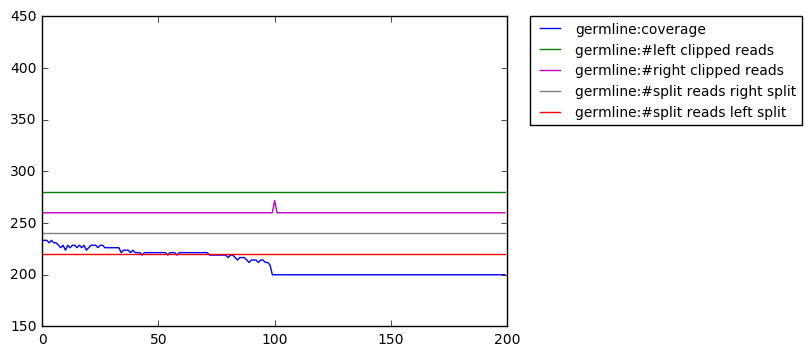

id: 160
Nanopore: DEL_end . DeepSV: noSV


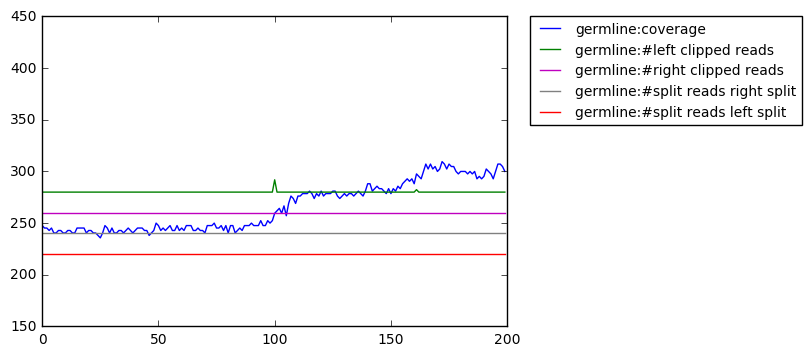

id: 188
Nanopore: DEL_start . DeepSV: noSV


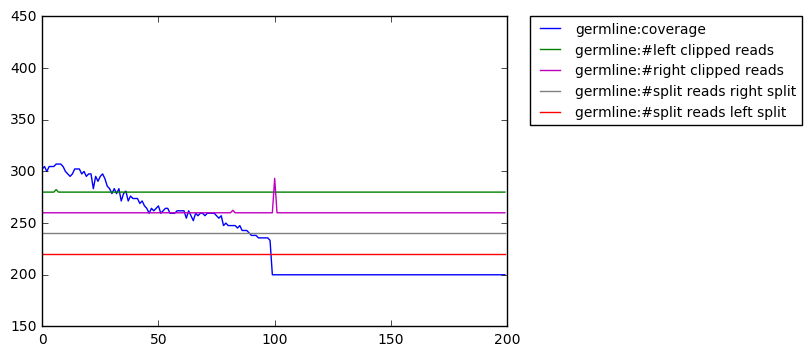

id: 258
Nanopore: DEL_end . DeepSV: noSV


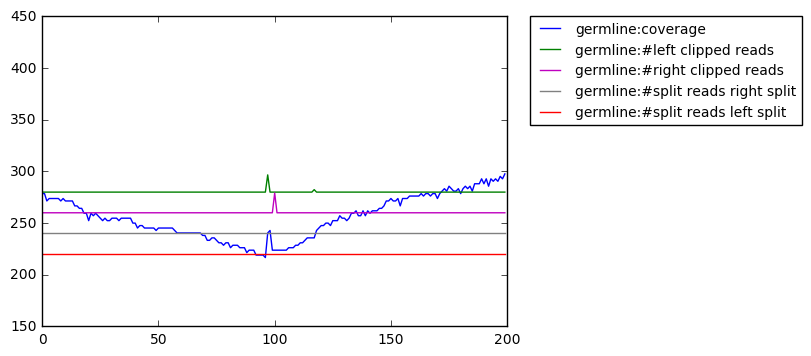

id: 295
Nanopore: DEL_start . DeepSV: noSV


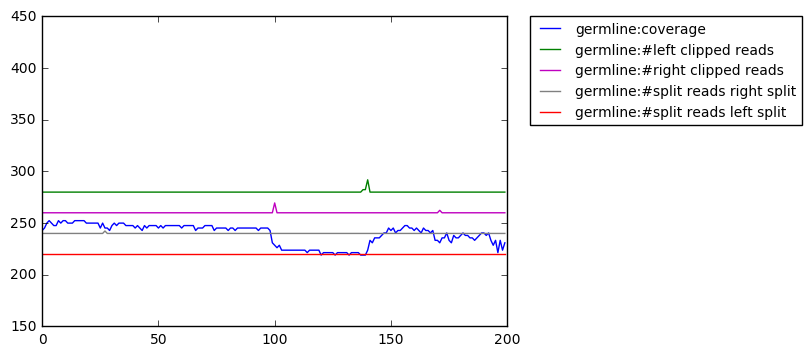

id: 296
Nanopore: DEL_start . DeepSV: noSV


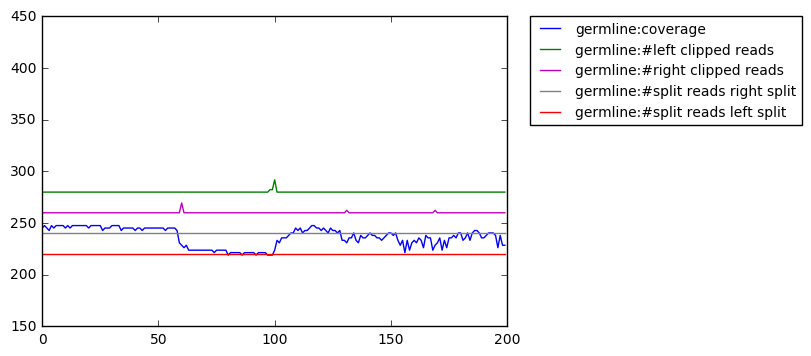

id: 297
Nanopore: DEL_end . DeepSV: noSV


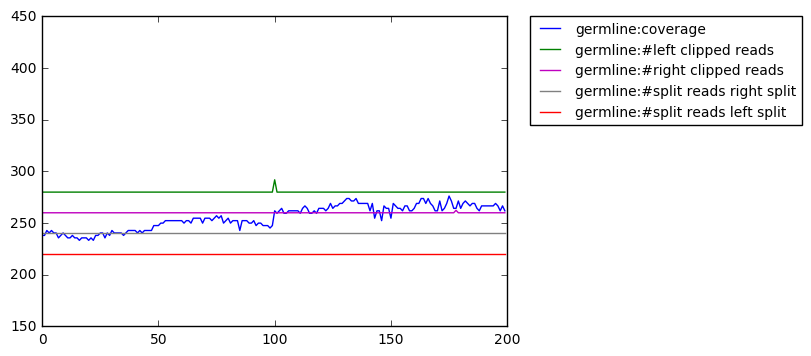

id: 308
Nanopore: DEL_end . DeepSV: DEL_start


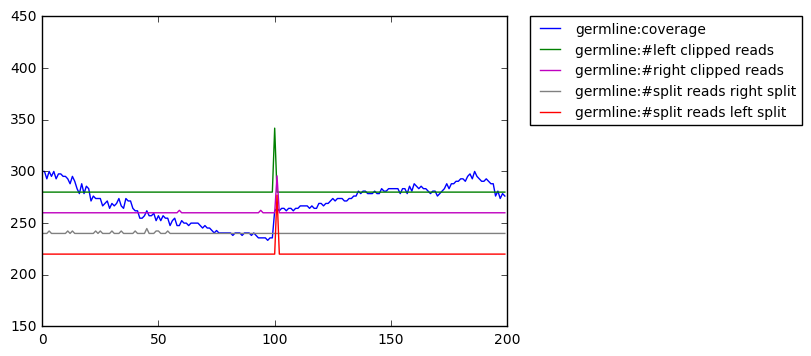

id: 496
Nanopore: DEL_end . DeepSV: DEL_start


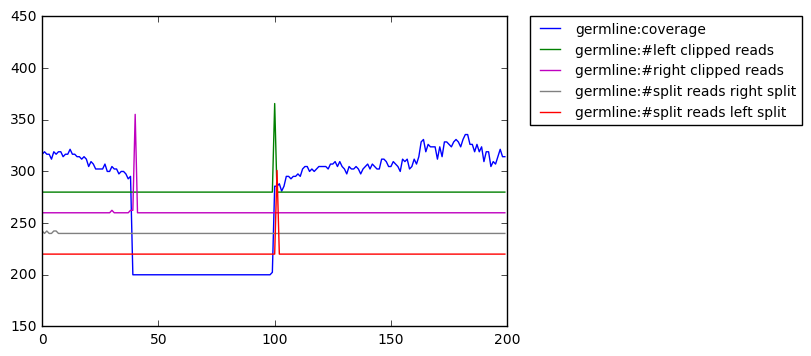

id: 560
Nanopore: DEL_start . DeepSV: noSV


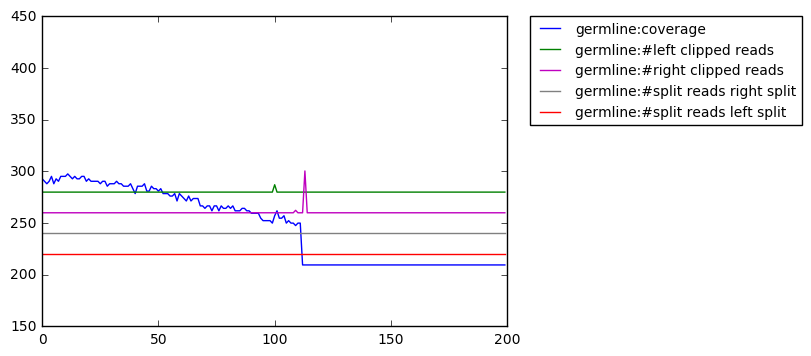

id: 594
Nanopore: DEL_end . DeepSV: noSV


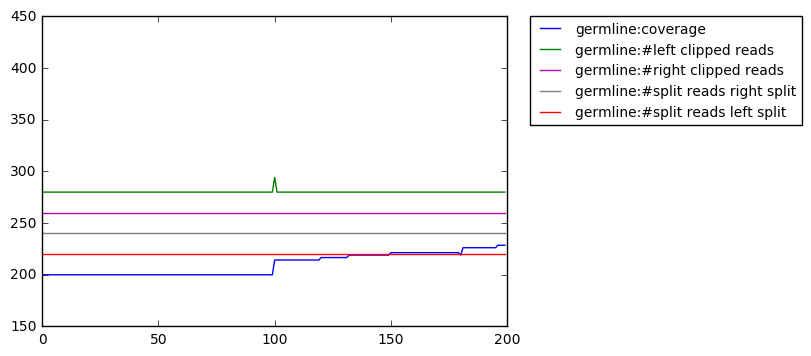

id: 607
Nanopore: DEL_start . DeepSV: noSV


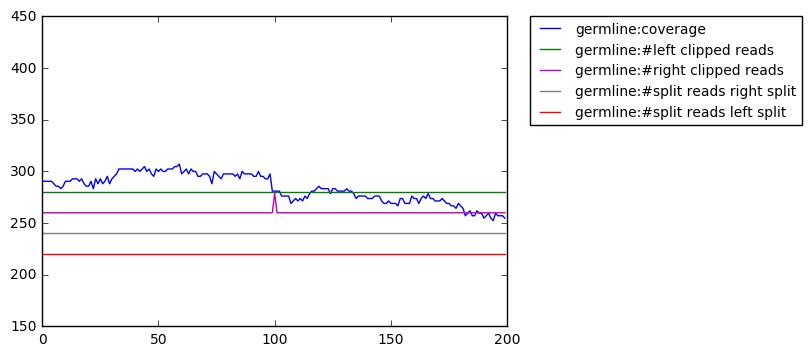

id: 637
Nanopore: DEL_end . DeepSV: noSV


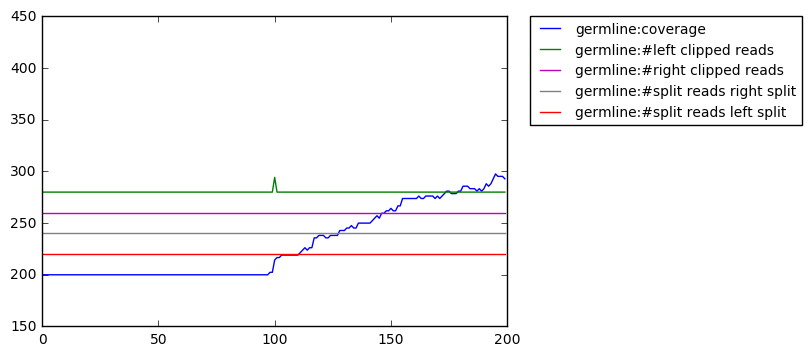

id: 722
Nanopore: DEL_end . DeepSV: noSV


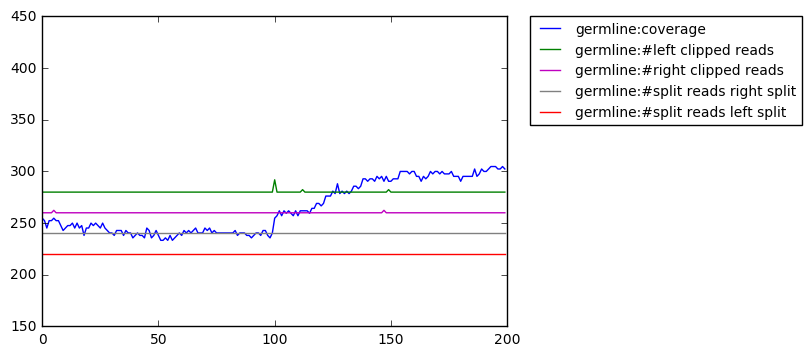

id: 866
Nanopore: DEL_start . DeepSV: noSV


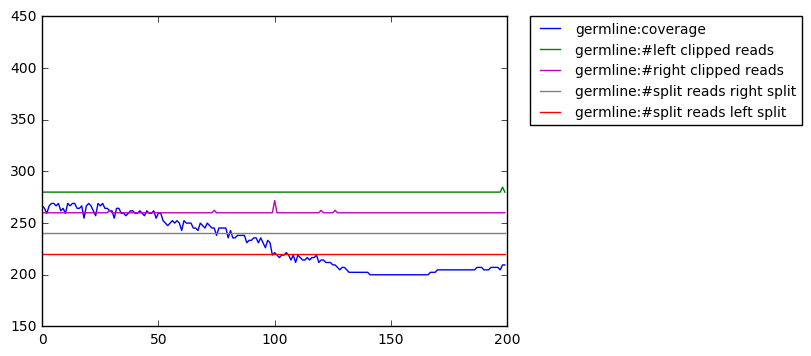

id: 1003
Nanopore: DEL_end . DeepSV: noSV


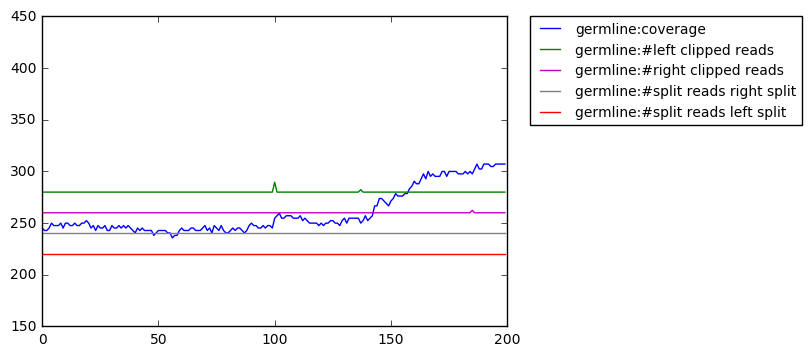

id: 1035
Nanopore: DEL_start . DeepSV: noSV


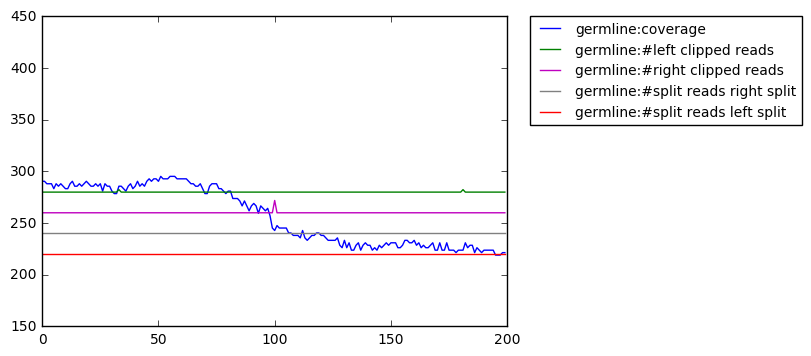

id: 1058
Nanopore: DEL_start . DeepSV: DEL_end


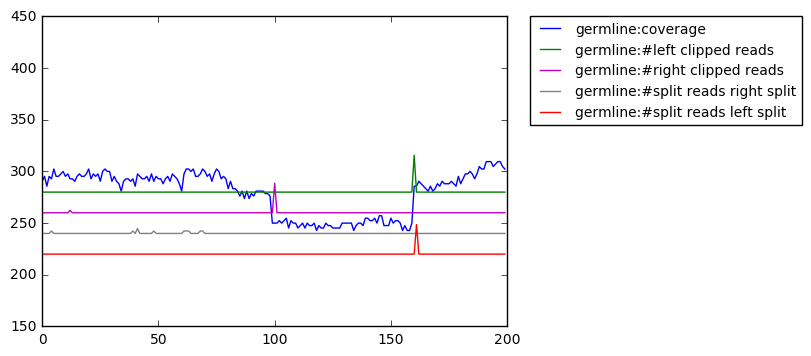

id: 1166
Nanopore: DEL_end . DeepSV: DEL_start


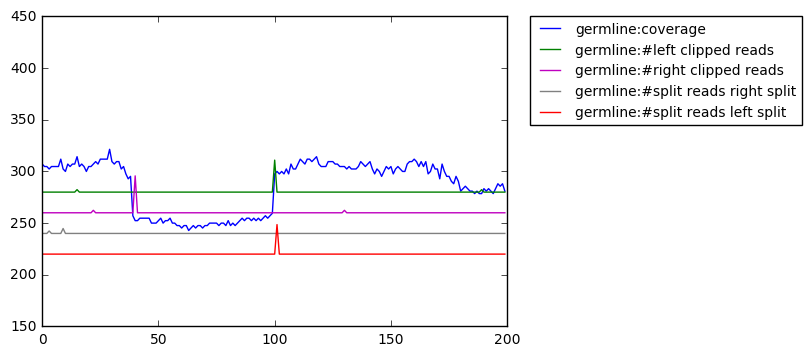

id: 1363
Nanopore: DEL_start . DeepSV: noSV


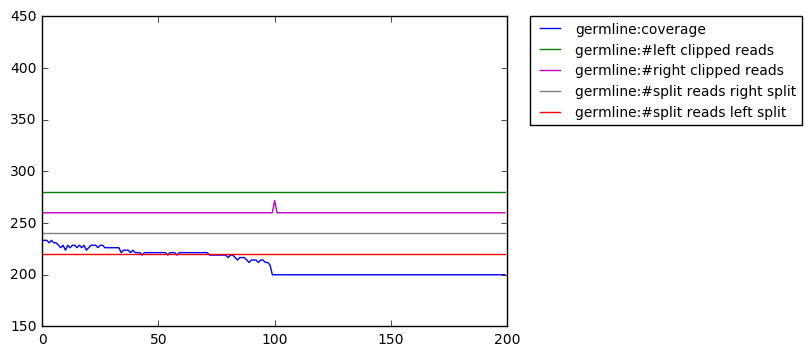

id: 1399
Nanopore: DEL_end . DeepSV: noSV


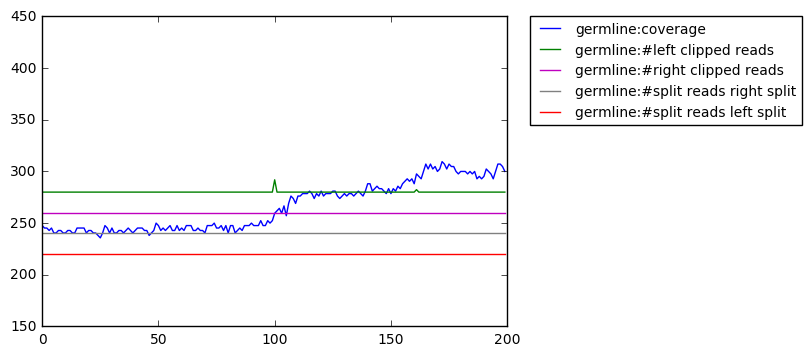

id: 1427
Nanopore: DEL_start . DeepSV: noSV


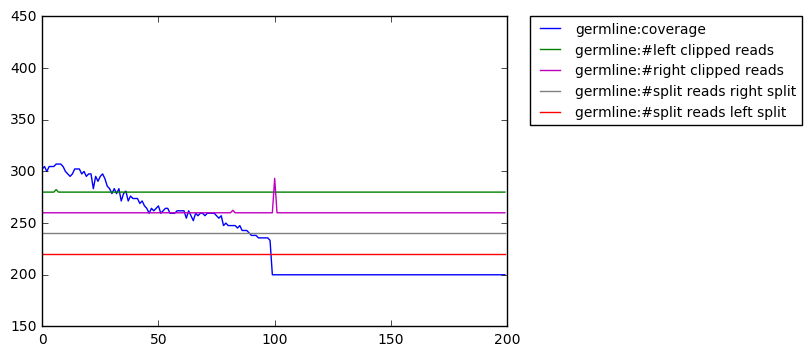

id: 1497
Nanopore: DEL_end . DeepSV: noSV


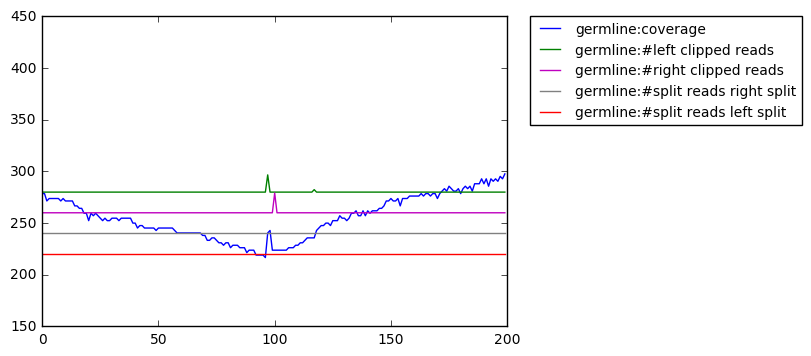

id: 1534
Nanopore: DEL_start . DeepSV: noSV


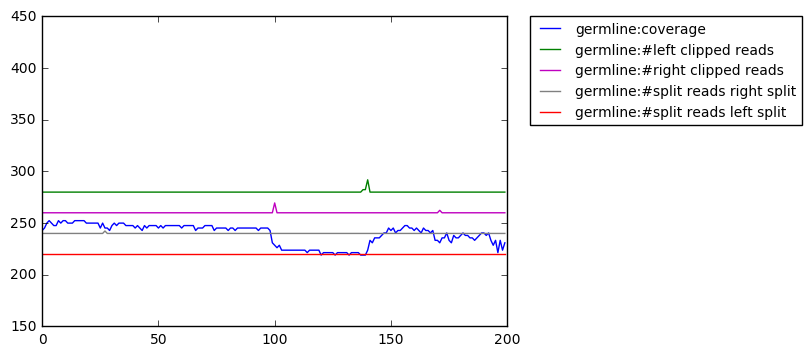

id: 1535
Nanopore: DEL_start . DeepSV: noSV


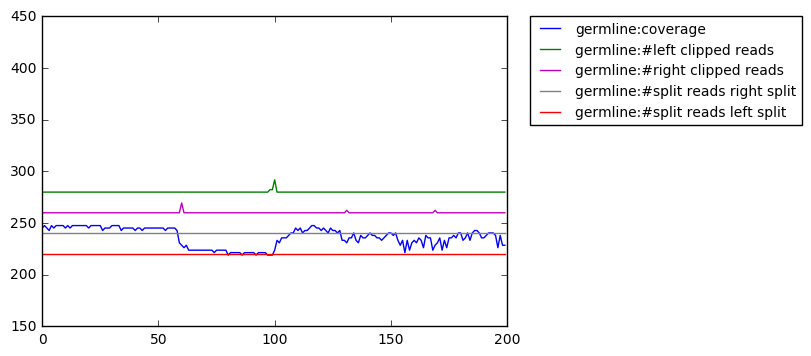

id: 1536
Nanopore: DEL_end . DeepSV: noSV


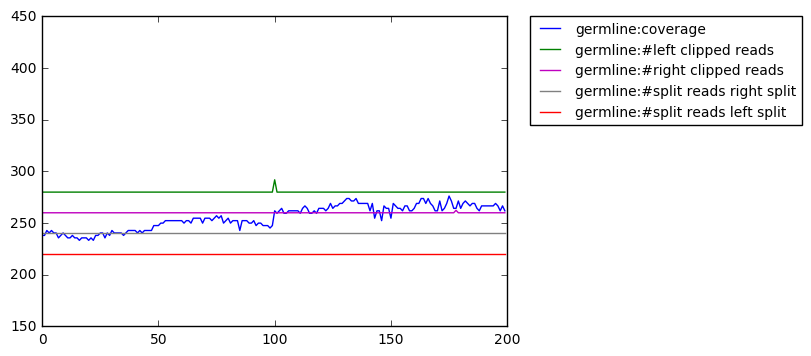

id: 1547
Nanopore: DEL_end . DeepSV: DEL_start


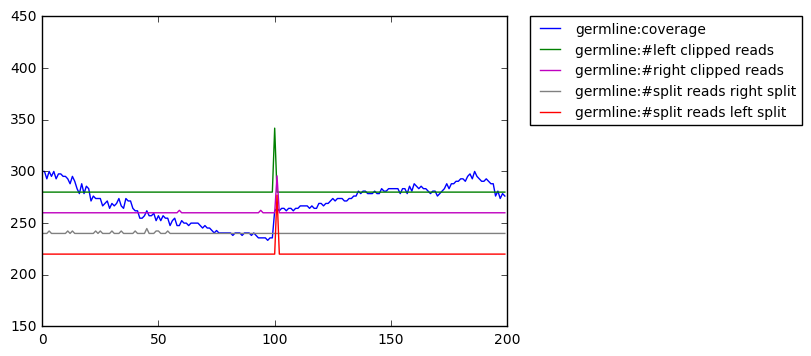

id: 1735
Nanopore: DEL_end . DeepSV: DEL_start


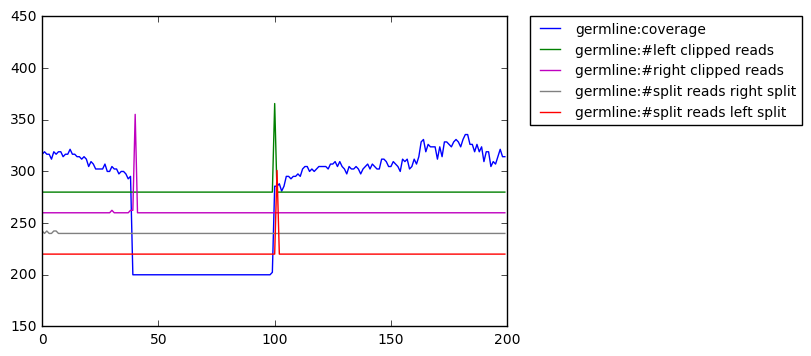

id: 1799
Nanopore: DEL_start . DeepSV: noSV


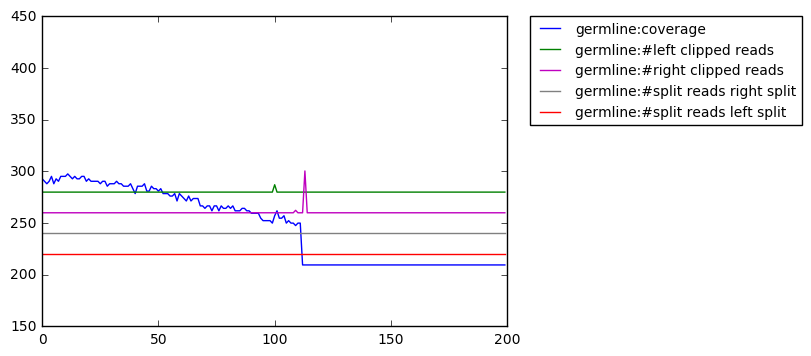

id: 1833
Nanopore: DEL_end . DeepSV: noSV


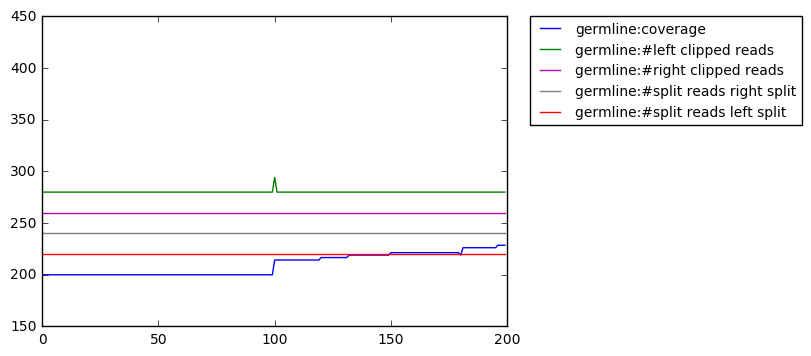

id: 1846
Nanopore: DEL_start . DeepSV: noSV


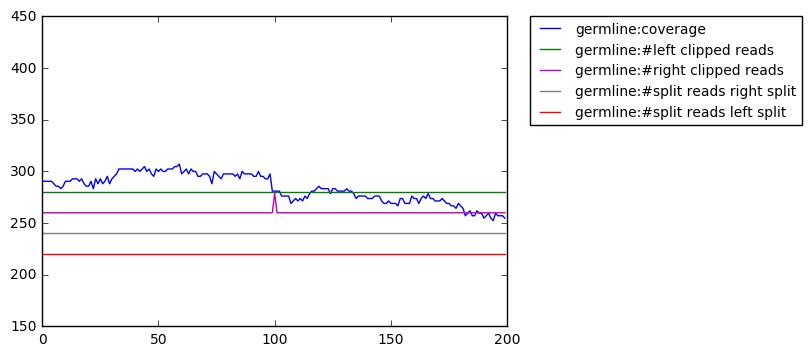

id: 1876
Nanopore: DEL_end . DeepSV: noSV


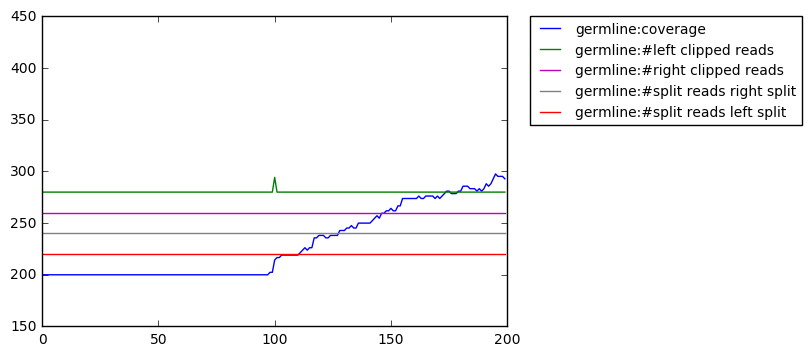

id: 1961
Nanopore: DEL_end . DeepSV: noSV


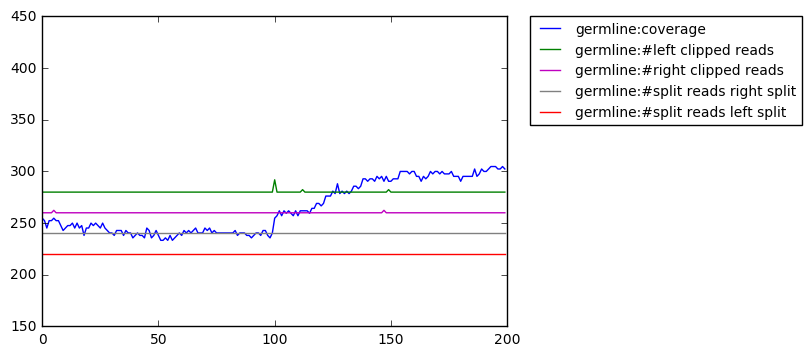

id: 2105
Nanopore: DEL_start . DeepSV: noSV


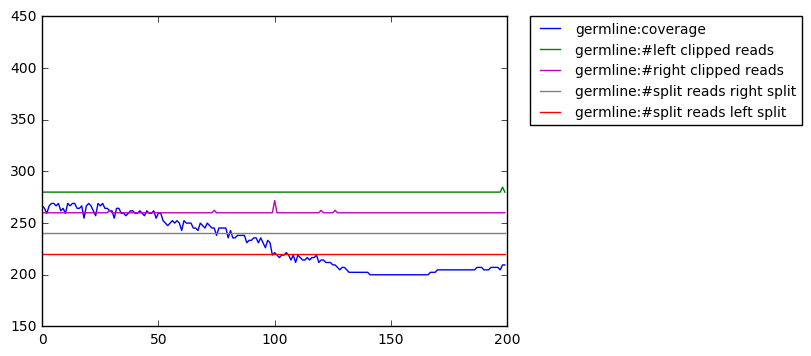

id: 2242
Nanopore: DEL_end . DeepSV: noSV


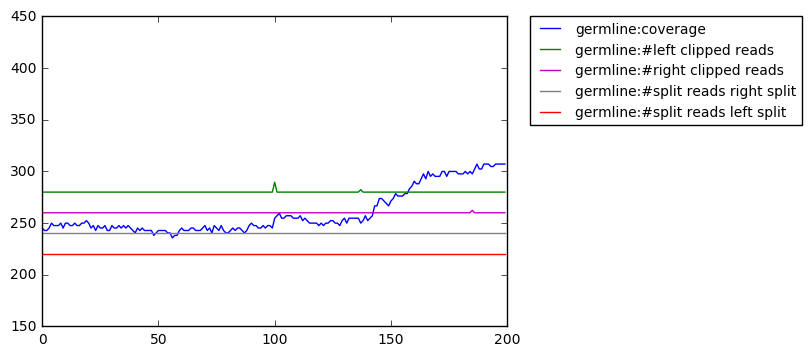

id: 2274
Nanopore: DEL_start . DeepSV: noSV


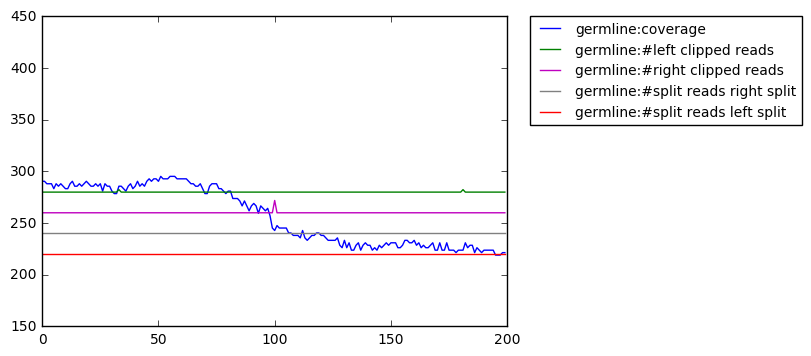

id: 2297
Nanopore: DEL_start . DeepSV: DEL_end


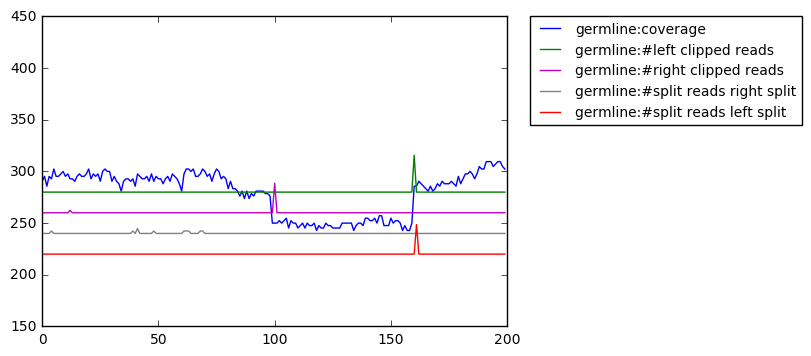

id: 2405
Nanopore: DEL_end . DeepSV: DEL_start


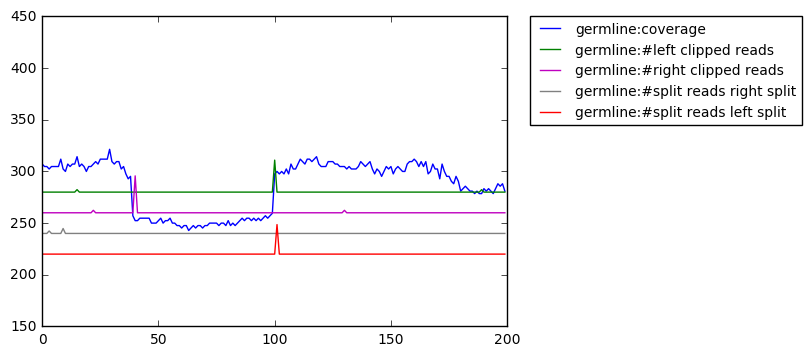

id: 2566
Nanopore: noSV . DeepSV: DEL_end


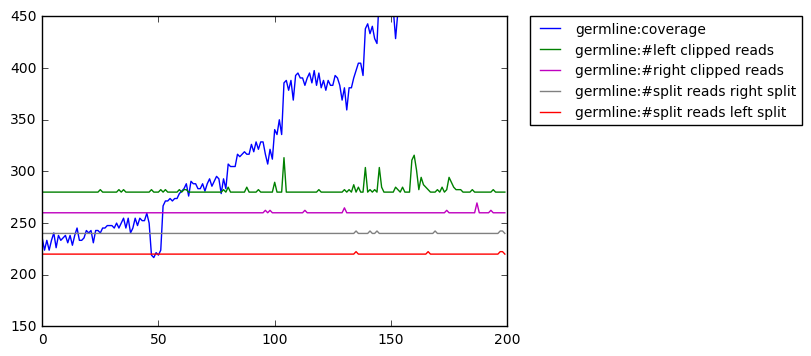

id: 2600
Nanopore: noSV . DeepSV: DEL_end


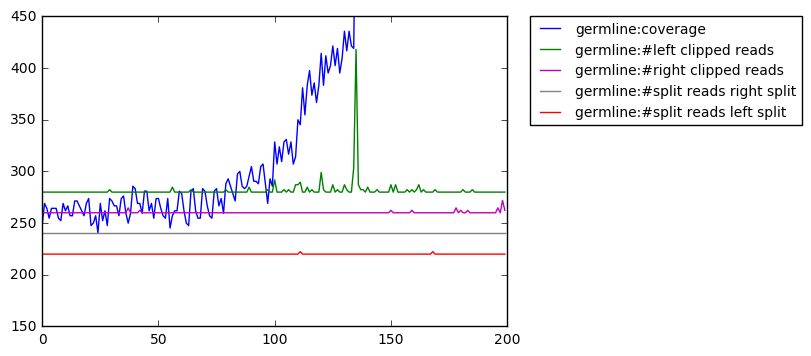

id: 2602
Nanopore: noSV . DeepSV: DEL_end


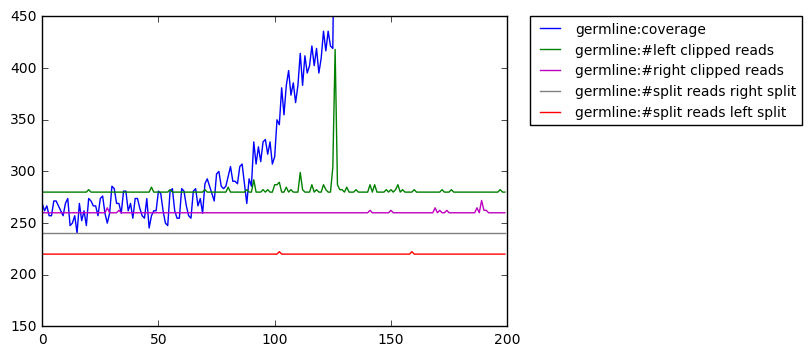

id: 2604
Nanopore: noSV . DeepSV: DEL_end


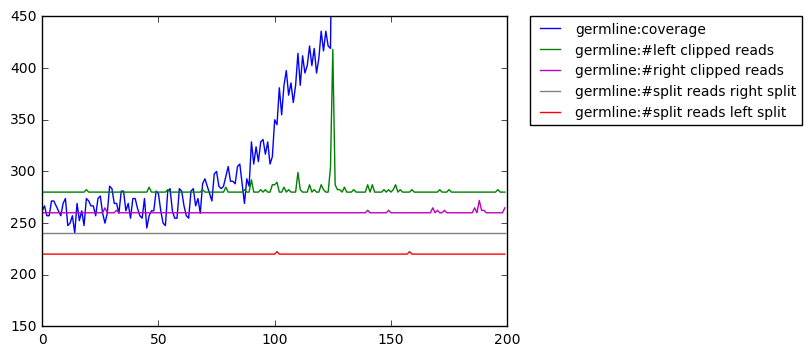

id: 2605
Nanopore: noSV . DeepSV: DEL_end


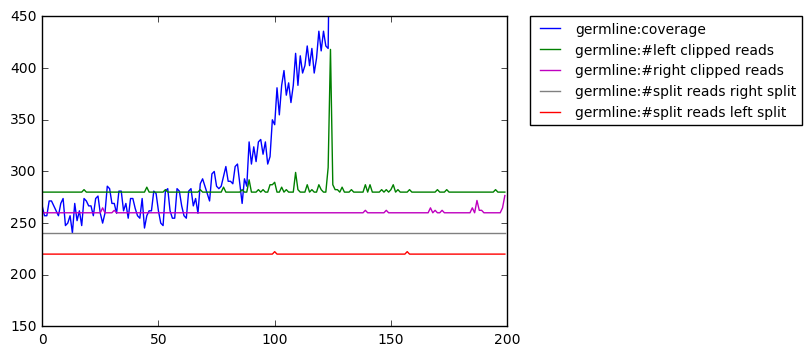

id: 2613
Nanopore: noSV . DeepSV: DEL_end


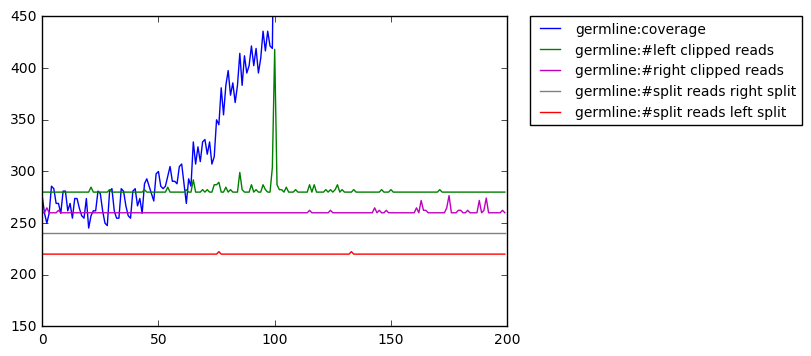

id: 2828
Nanopore: noSV . DeepSV: DEL_start


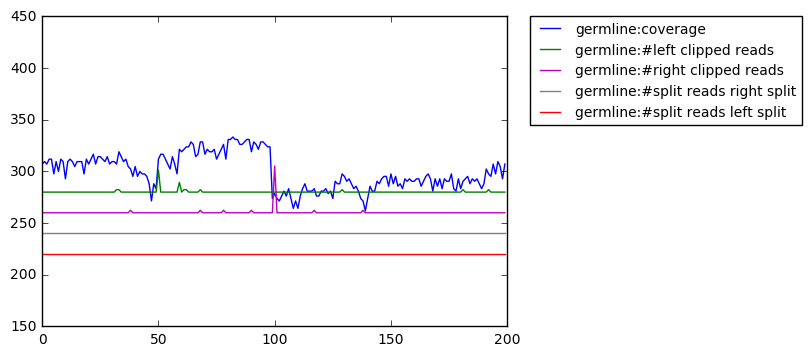

id: 2924
Nanopore: noSV . DeepSV: DEL_start


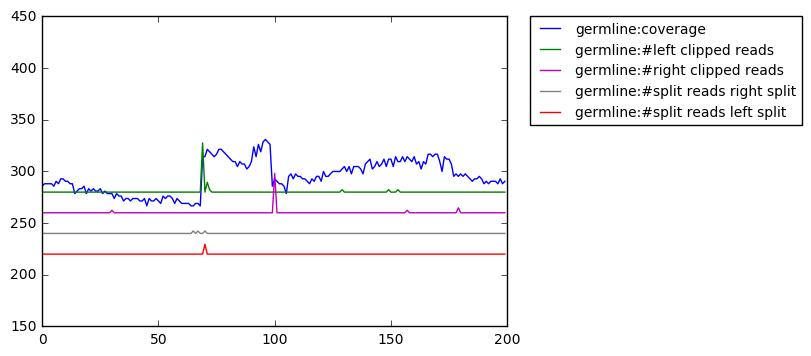

id: 2925
Nanopore: noSV . DeepSV: DEL_start


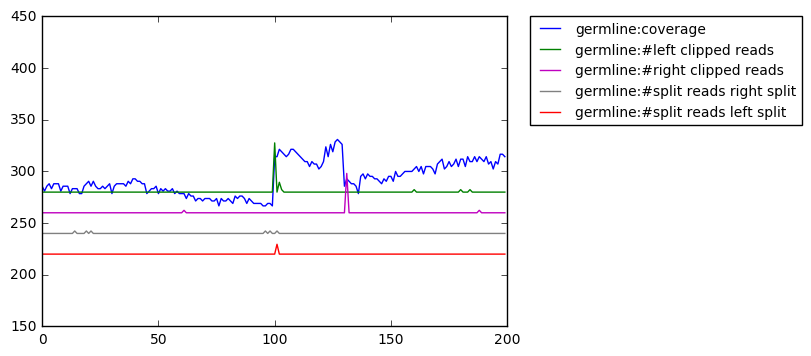

id: 2926
Nanopore: noSV . DeepSV: DEL_start


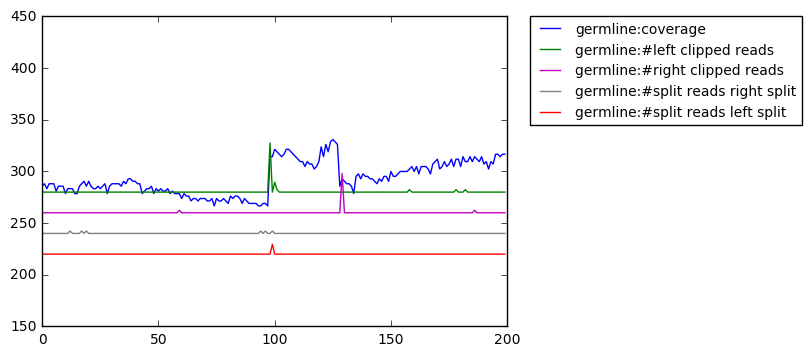

id: 2932
Nanopore: noSV . DeepSV: DEL_start


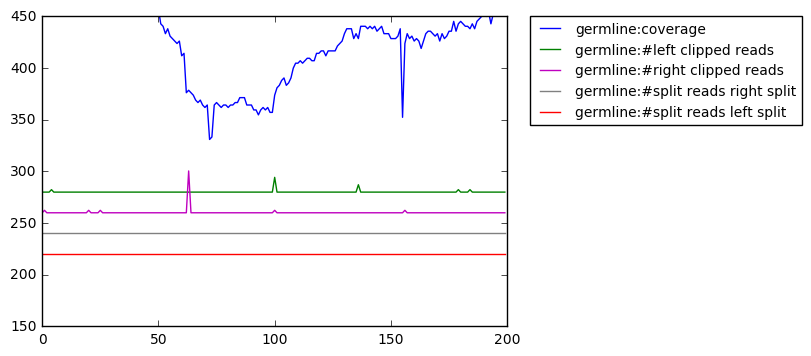

id: 2965
Nanopore: noSV . DeepSV: DEL_end


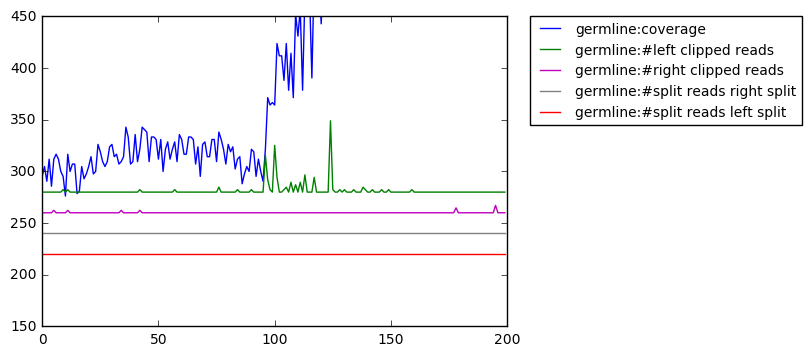

id: 3047
Nanopore: noSV . DeepSV: DEL_start


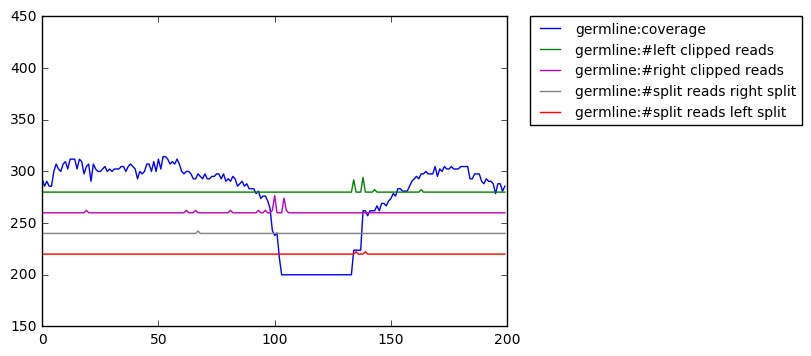

id: 3049
Nanopore: noSV . DeepSV: DEL_end


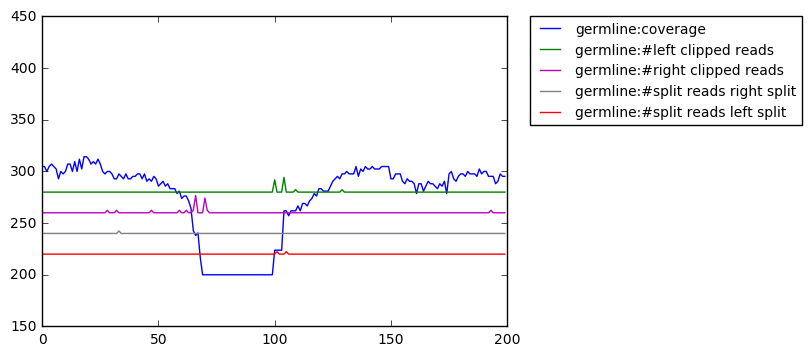

id: 3050
Nanopore: noSV . DeepSV: DEL_end


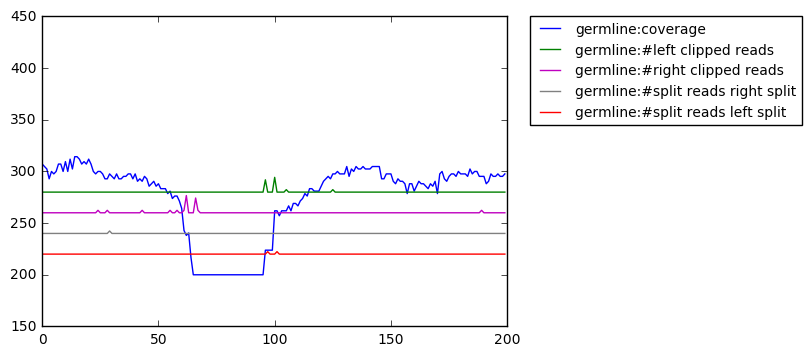

id: 3059
Nanopore: noSV . DeepSV: DEL_start


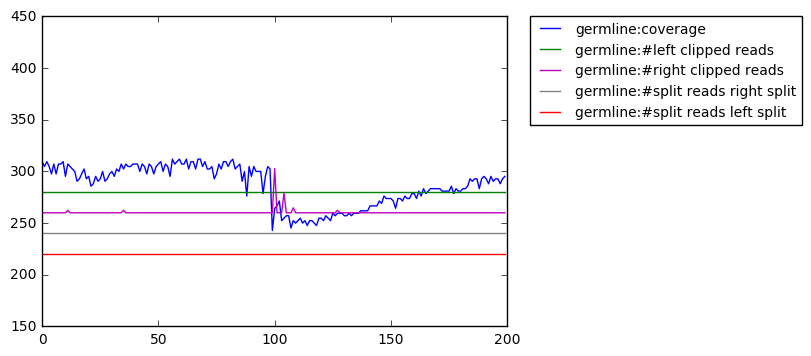

id: 3066
Nanopore: noSV . DeepSV: DEL_start


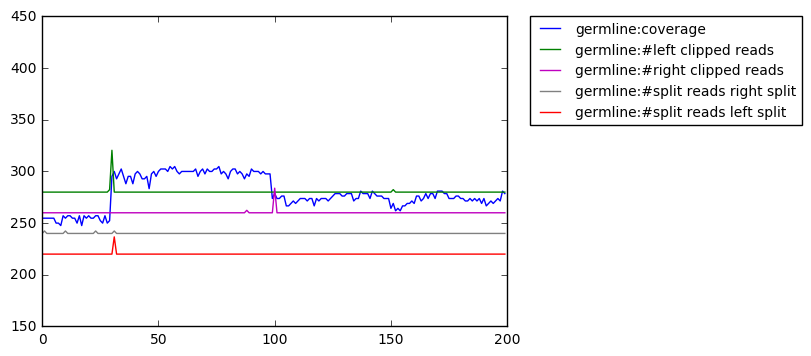

id: 3067
Nanopore: noSV . DeepSV: DEL_end


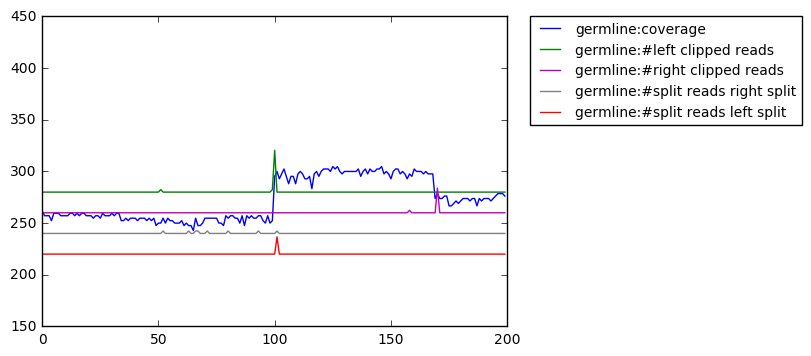

id: 3084
Nanopore: noSV . DeepSV: DEL_end


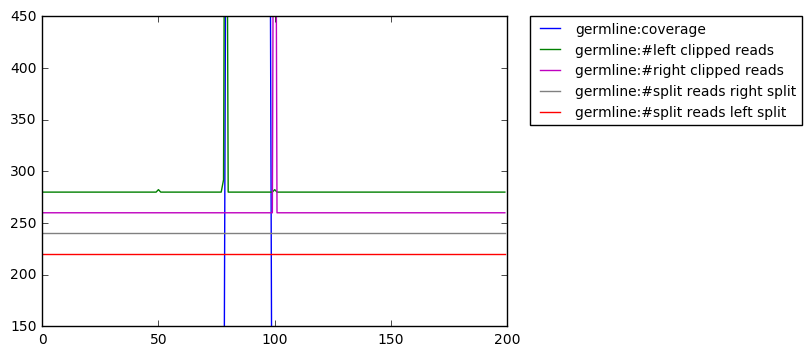

id: 3085
Nanopore: noSV . DeepSV: DEL_end


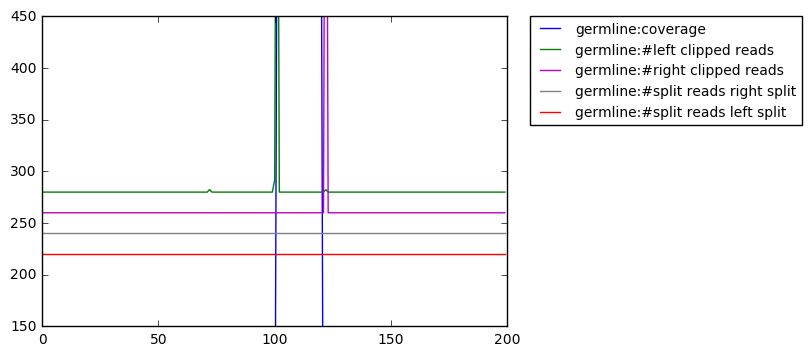

id: 3086
Nanopore: noSV . DeepSV: DEL_end


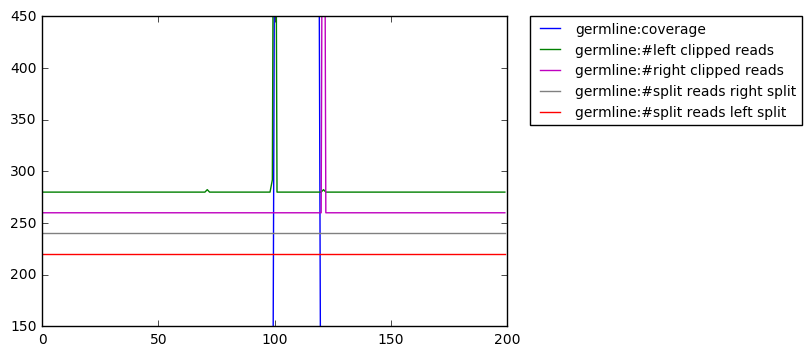

id: 3102
Nanopore: noSV . DeepSV: DEL_start


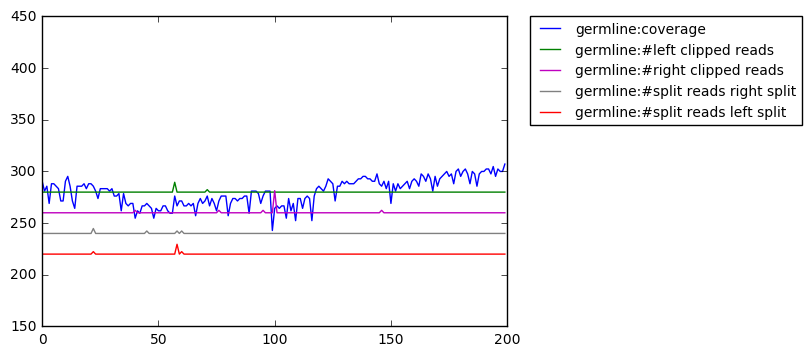

id: 3103
Nanopore: noSV . DeepSV: DEL_start


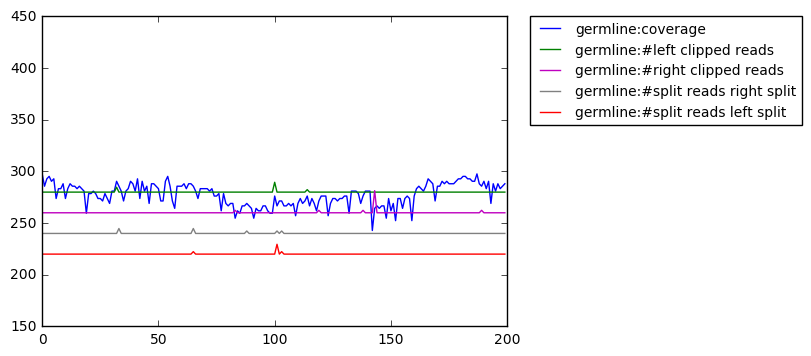

id: 3107
Nanopore: noSV . DeepSV: DEL_start


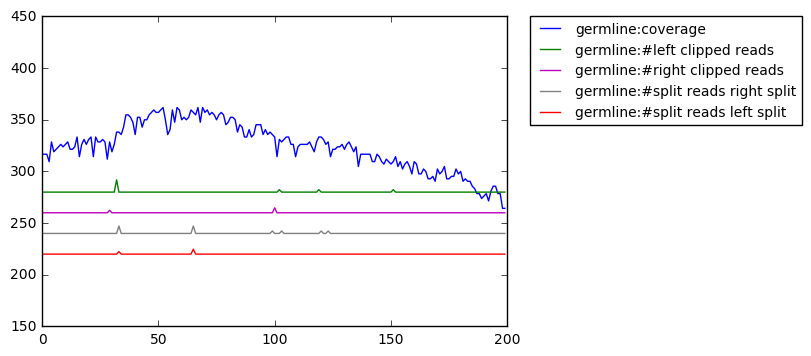

id: 3127
Nanopore: noSV . DeepSV: DEL_start


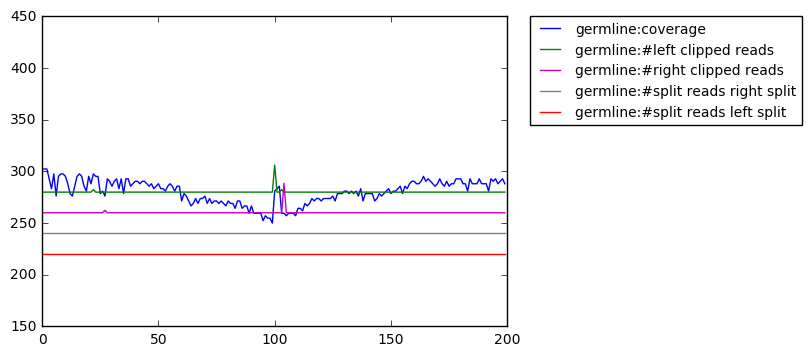

id: 3154
Nanopore: noSV . DeepSV: DEL_end


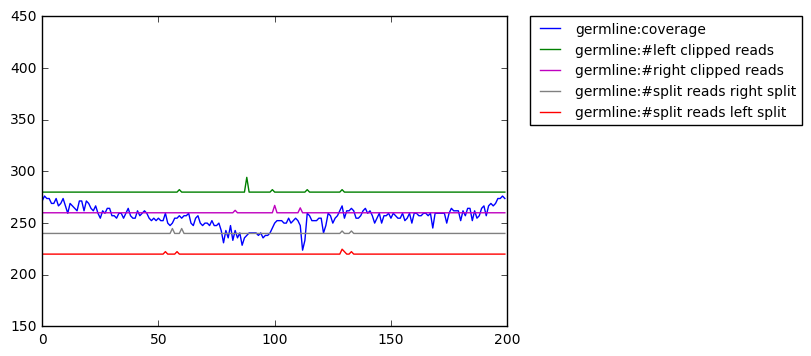

id: 3155
Nanopore: noSV . DeepSV: DEL_start


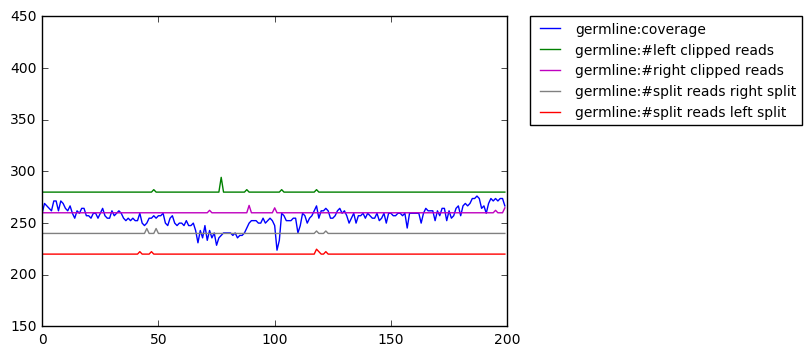

id: 3208
Nanopore: noSV . DeepSV: DEL_start


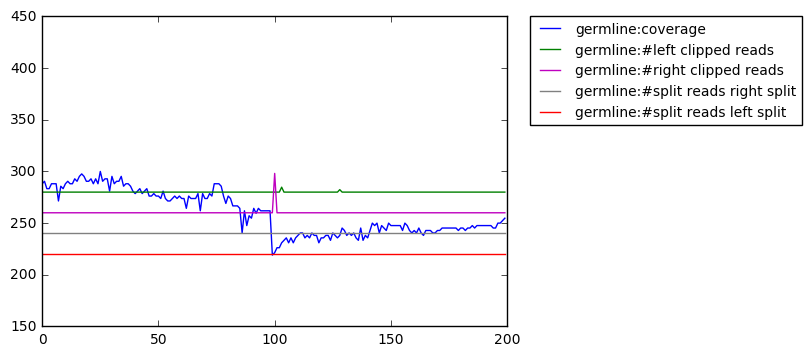

id: 3221
Nanopore: noSV . DeepSV: DEL_start


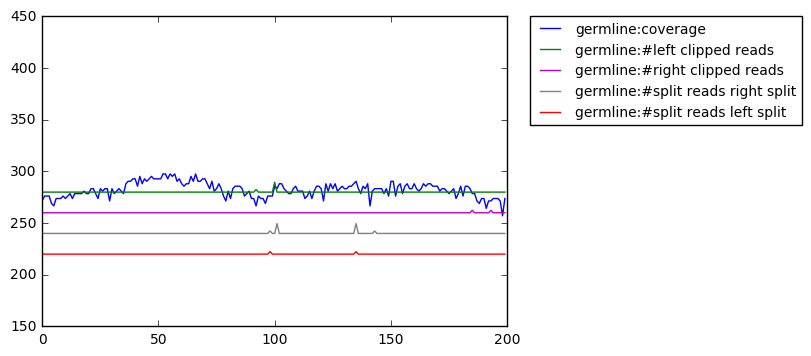

id: 3222
Nanopore: noSV . DeepSV: DEL_start


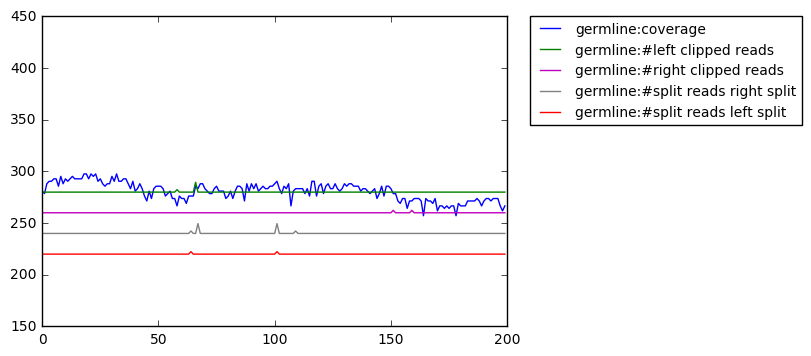

id: 3253
Nanopore: noSV . DeepSV: DEL_start


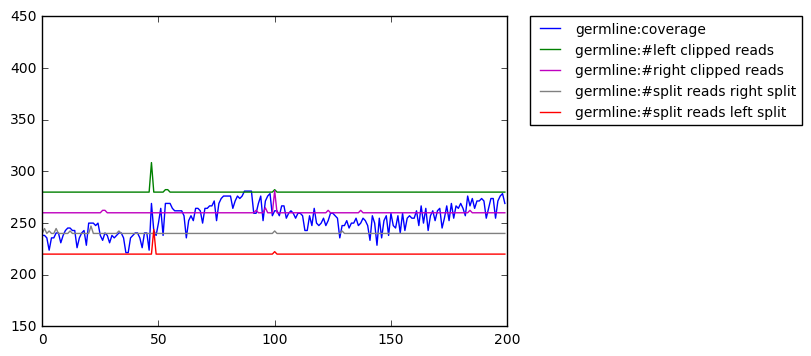

id: 3254
Nanopore: noSV . DeepSV: DEL_start


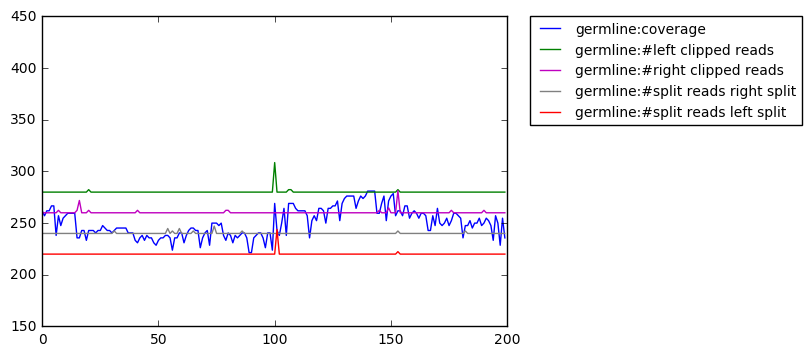

id: 3255
Nanopore: noSV . DeepSV: DEL_start


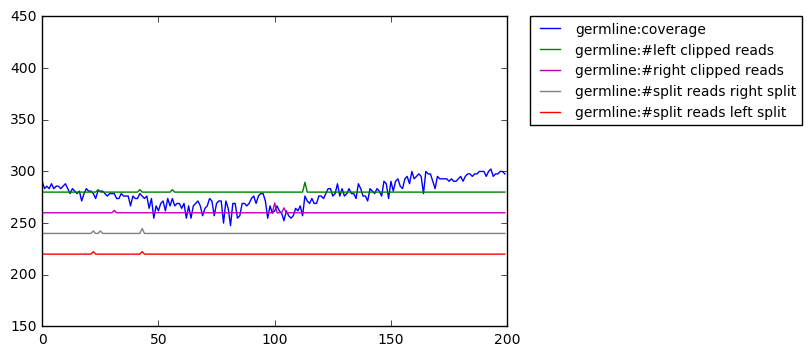

id: 3256
Nanopore: noSV . DeepSV: DEL_start


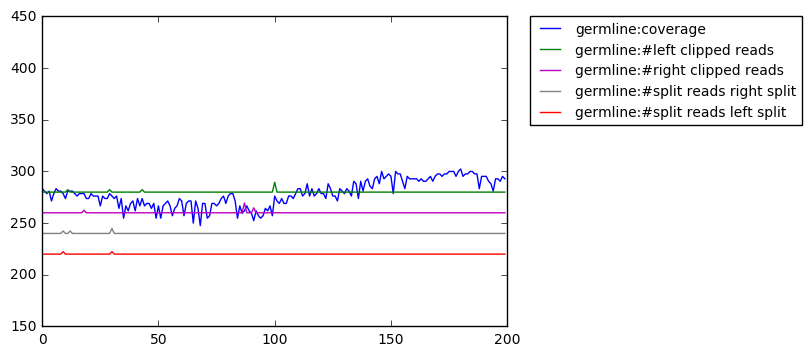

id: 3261
Nanopore: noSV . DeepSV: DEL_end


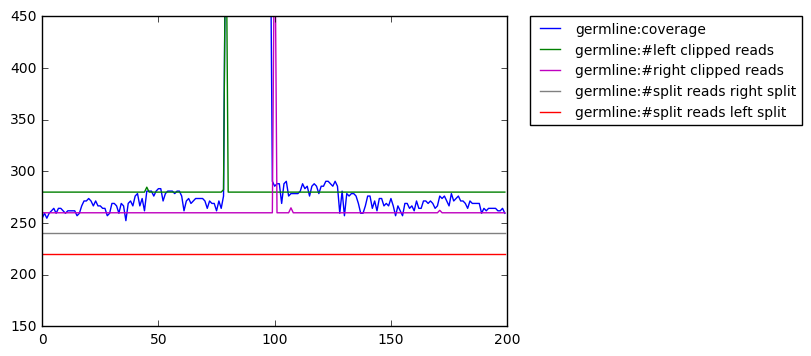

id: 3262
Nanopore: noSV . DeepSV: DEL_end


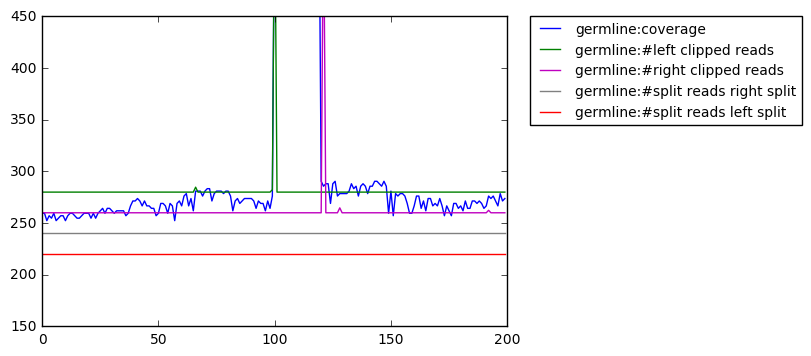

id: 3301
Nanopore: noSV . DeepSV: DEL_start


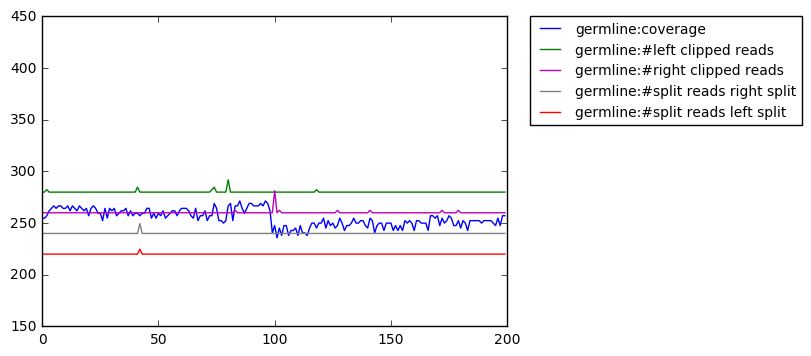

id: 3307
Nanopore: noSV . DeepSV: DEL_end


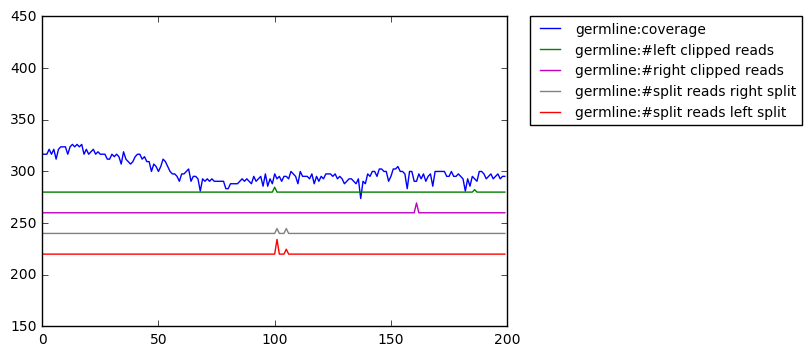

id: 3361
Nanopore: noSV . DeepSV: DEL_start


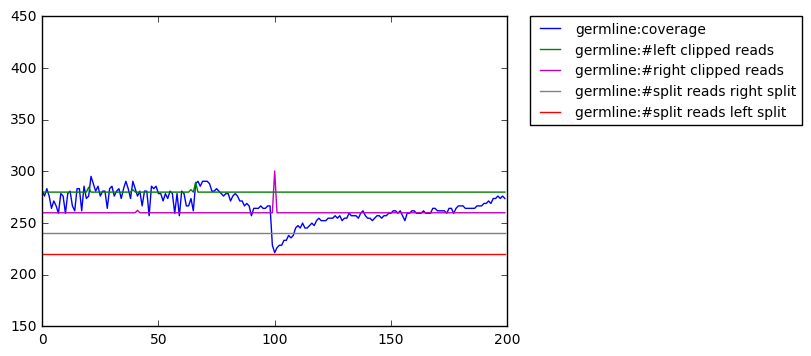

id: 3393
Nanopore: noSV . DeepSV: DEL_end


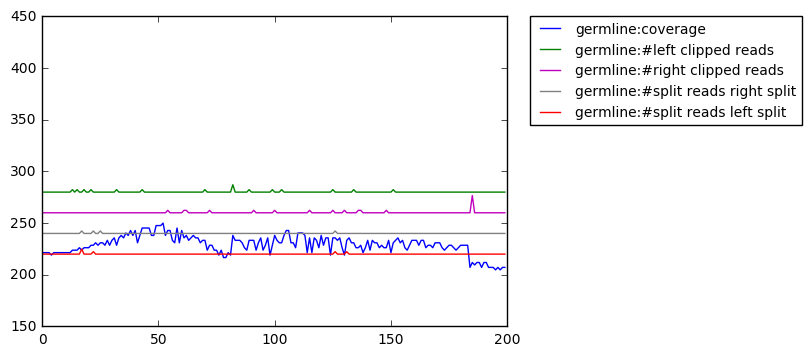

id: 3396
Nanopore: noSV . DeepSV: DEL_end


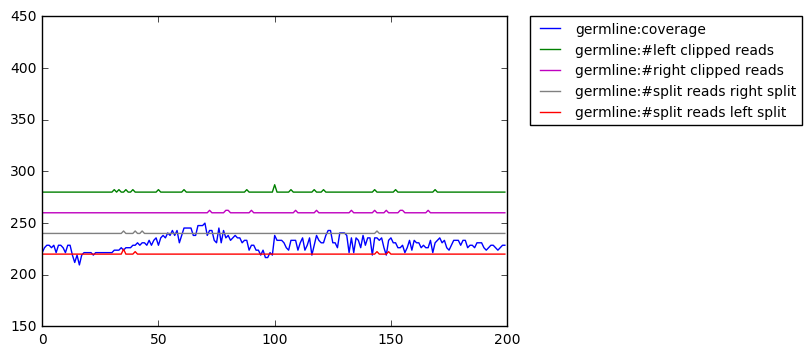

id: 3397
Nanopore: noSV . DeepSV: DEL_end


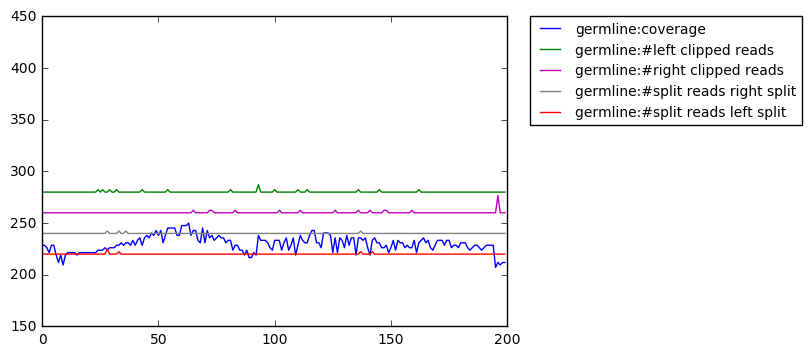

id: 3398
Nanopore: noSV . DeepSV: DEL_end


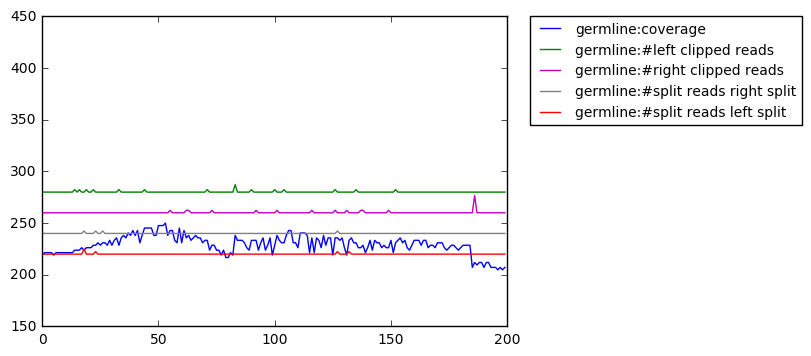

id: 3417
Nanopore: noSV . DeepSV: DEL_start


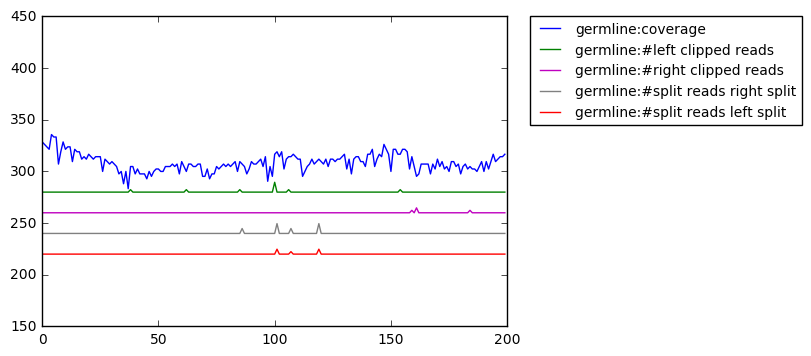

id: 3418
Nanopore: noSV . DeepSV: DEL_start


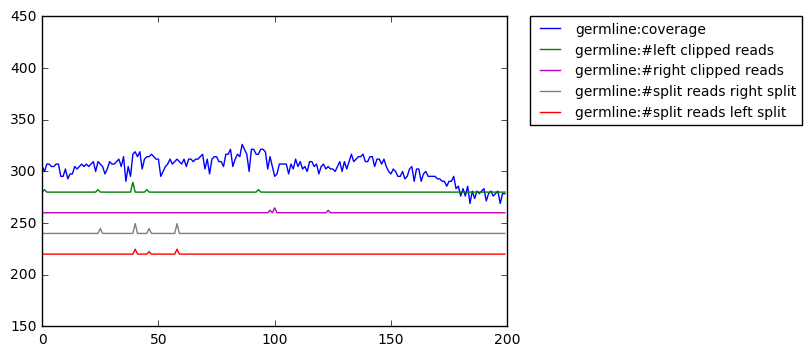

id: 3423
Nanopore: noSV . DeepSV: DEL_start


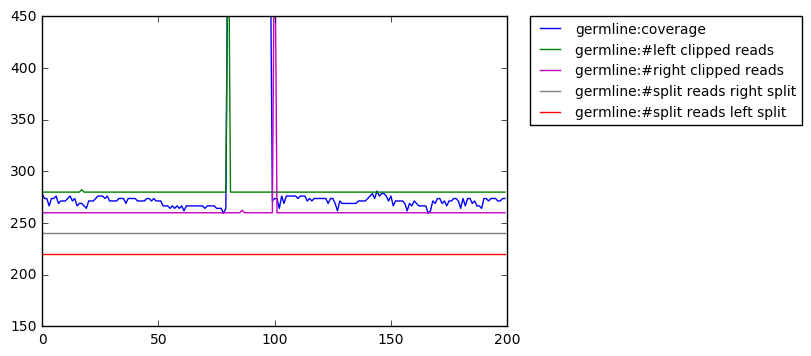

id: 3424
Nanopore: noSV . DeepSV: DEL_start


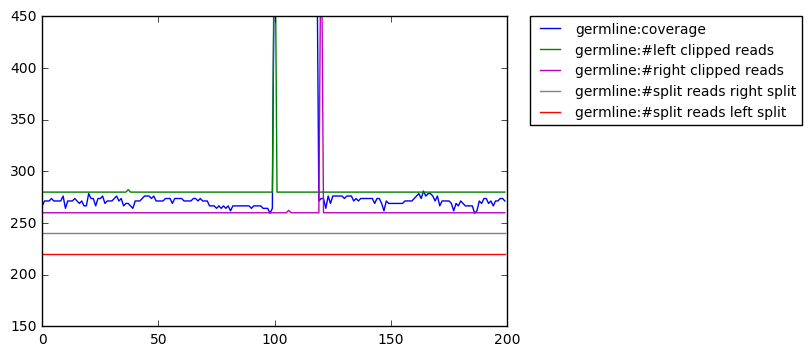

id: 3447
Nanopore: noSV . DeepSV: DEL_end


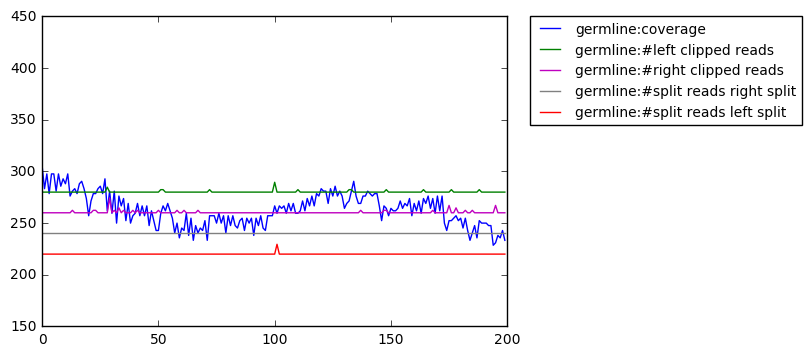

id: 3452
Nanopore: noSV . DeepSV: DEL_start


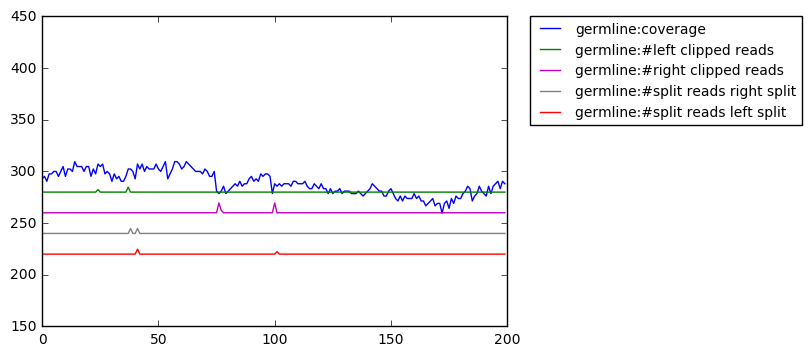

id: 3478
Nanopore: noSV . DeepSV: DEL_end


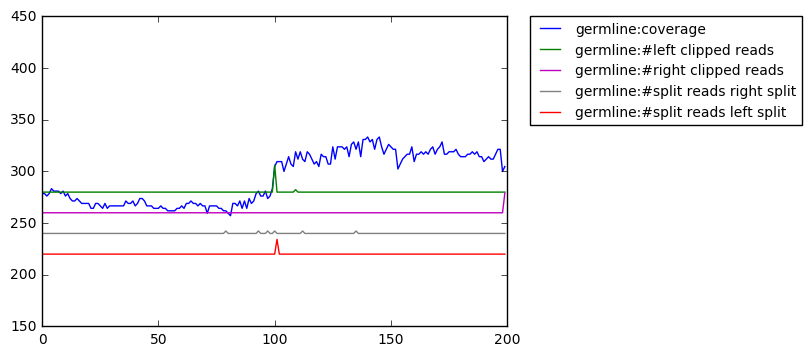

id: 3502
Nanopore: noSV . DeepSV: DEL_start


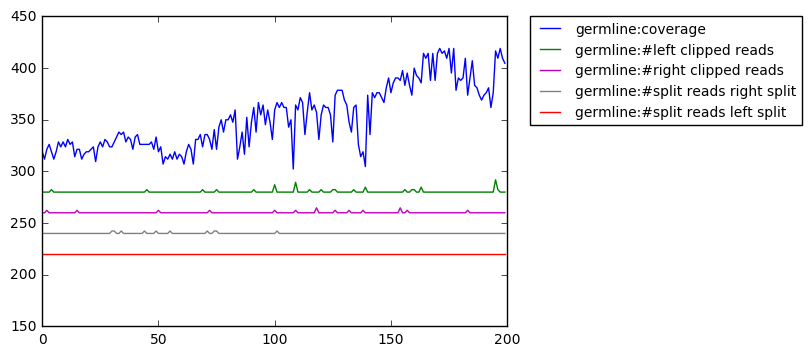

id: 3503
Nanopore: noSV . DeepSV: DEL_start


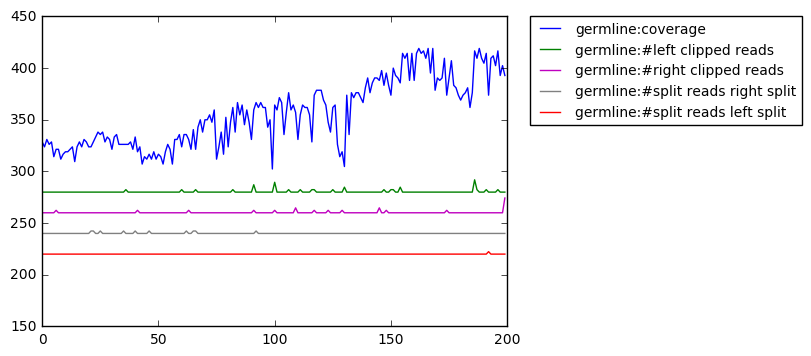

id: 3551
Nanopore: noSV . DeepSV: DEL_start


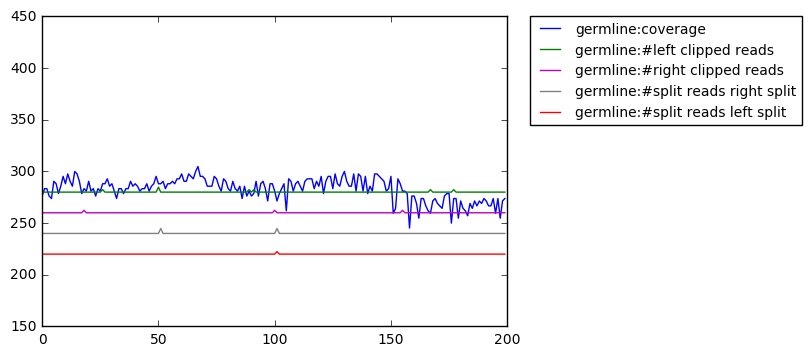

id: 3579
Nanopore: noSV . DeepSV: DEL_start


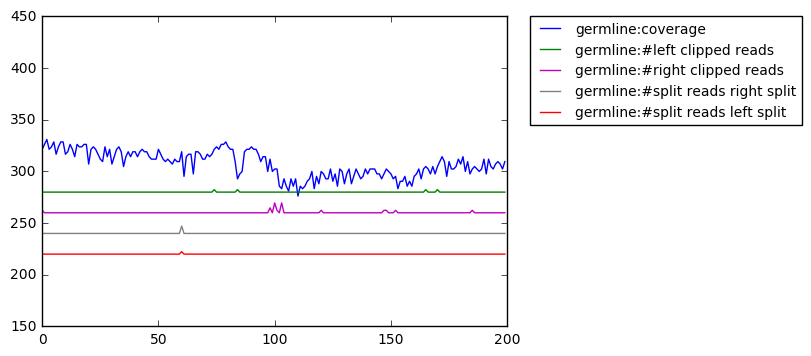

id: 3607
Nanopore: noSV . DeepSV: DEL_end


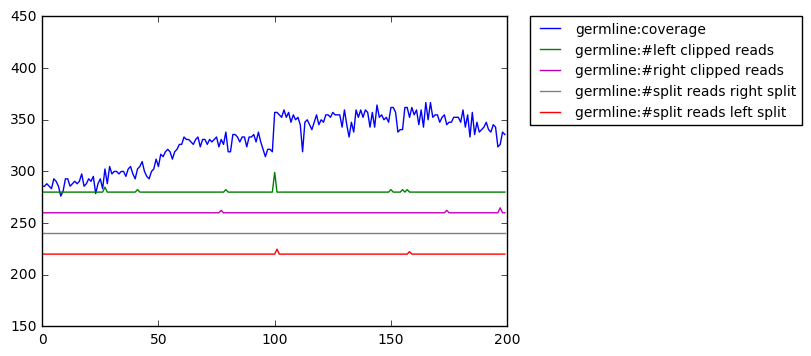

id: 3705
Nanopore: noSV . DeepSV: DEL_start


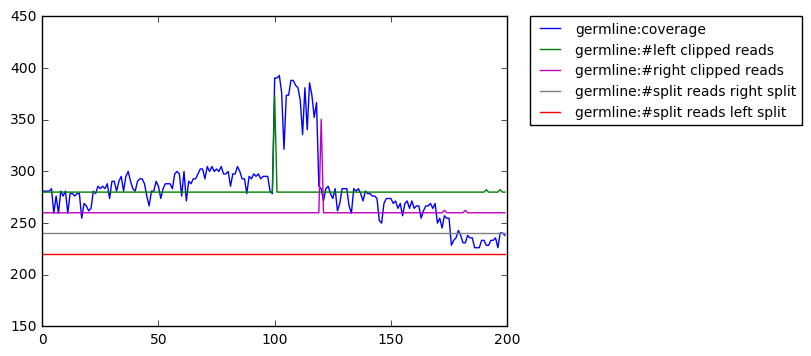

id: 3706
Nanopore: noSV . DeepSV: DEL_start


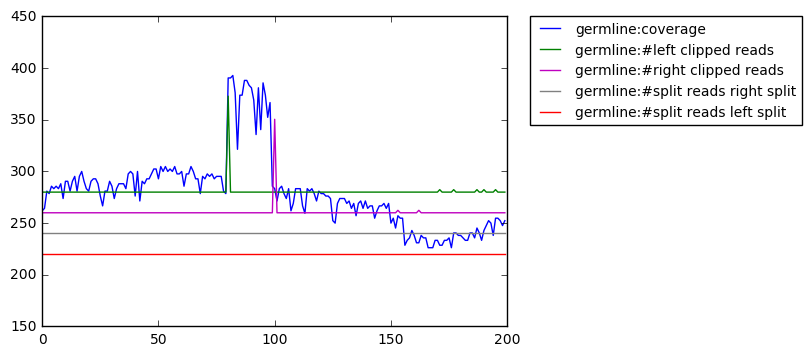

id: 3709
Nanopore: noSV . DeepSV: DEL_end


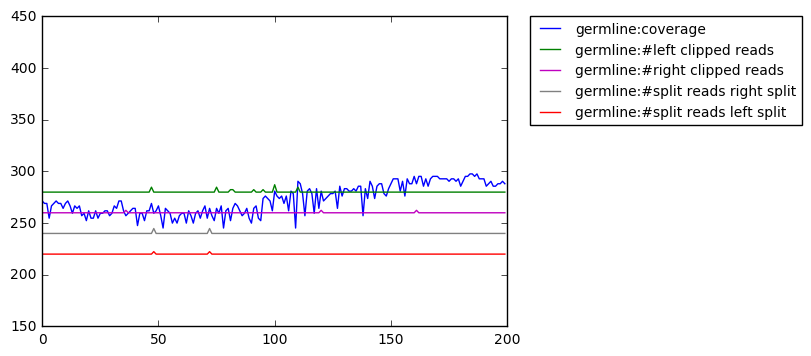

id: 3722
Nanopore: noSV . DeepSV: DEL_end


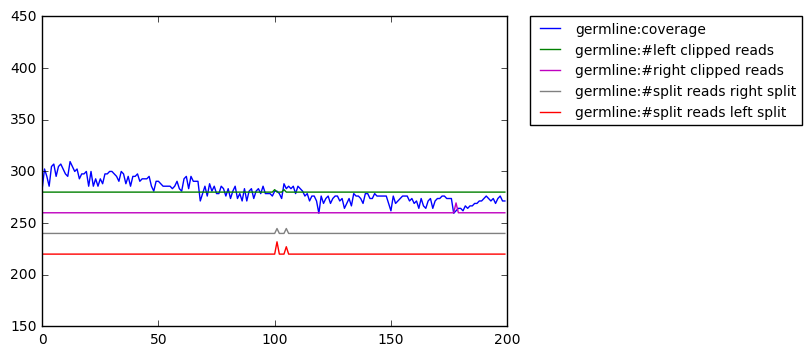

id: 3726
Nanopore: noSV . DeepSV: DEL_start


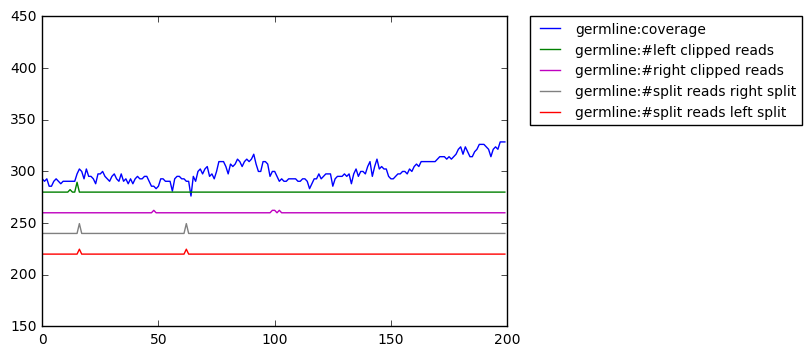

id: 3727
Nanopore: noSV . DeepSV: DEL_start


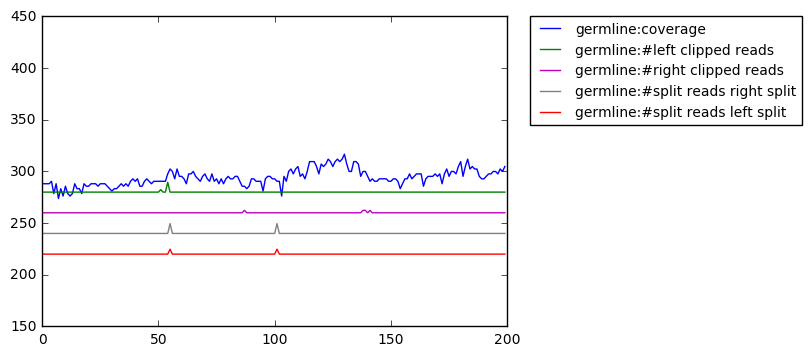

id: 3753
Nanopore: noSV . DeepSV: DEL_end


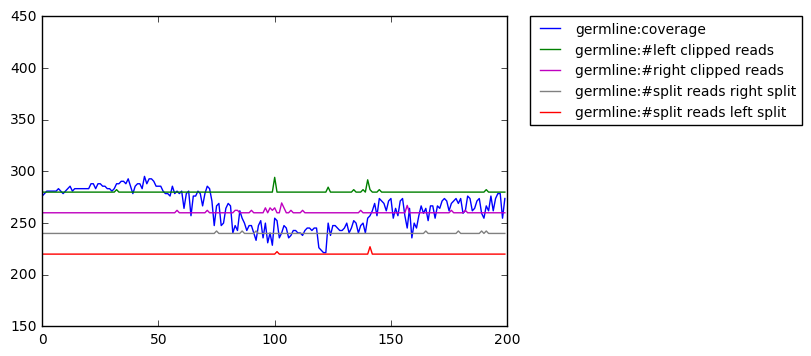

id: 3755
Nanopore: noSV . DeepSV: DEL_start


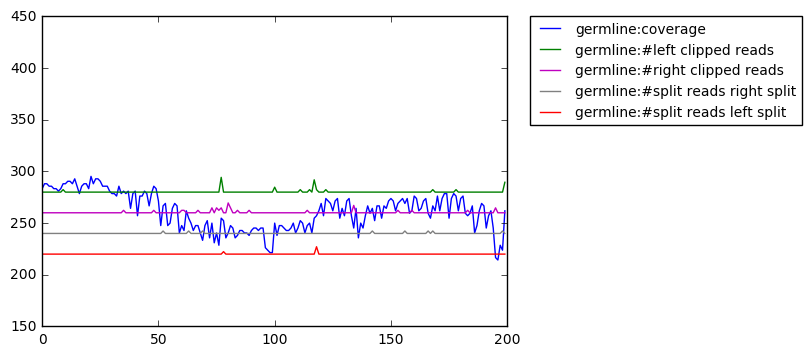

id: 3756
Nanopore: noSV . DeepSV: DEL_start


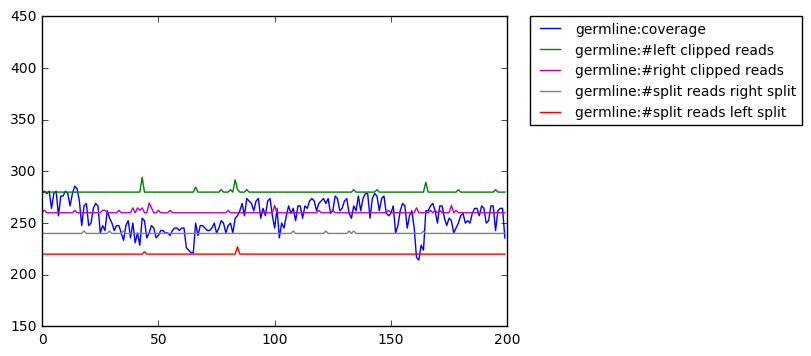

id: 3758
Nanopore: noSV . DeepSV: DEL_end


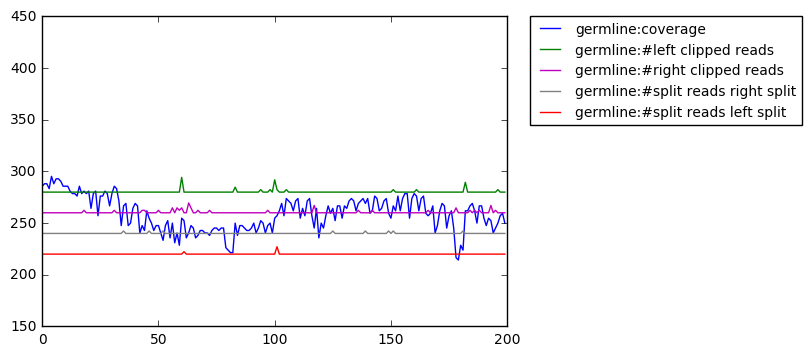

id: 3762
Nanopore: noSV . DeepSV: DEL_start


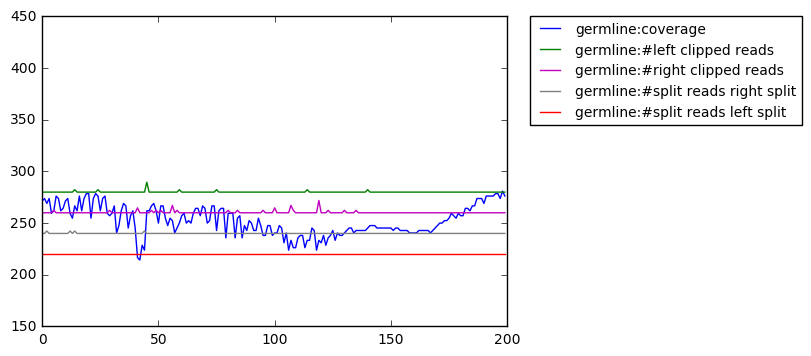

id: 3790
Nanopore: noSV . DeepSV: DEL_start


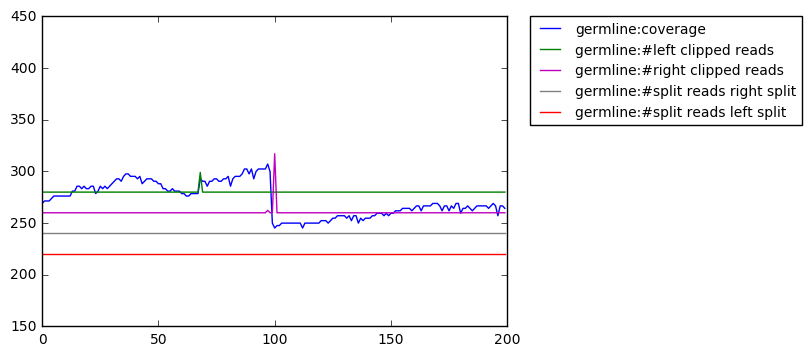

id: 3829
Nanopore: noSV . DeepSV: DEL_end


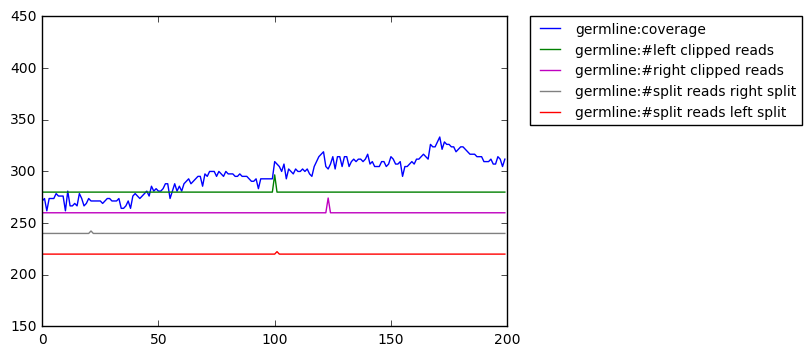

id: 3843
Nanopore: noSV . DeepSV: DEL_start


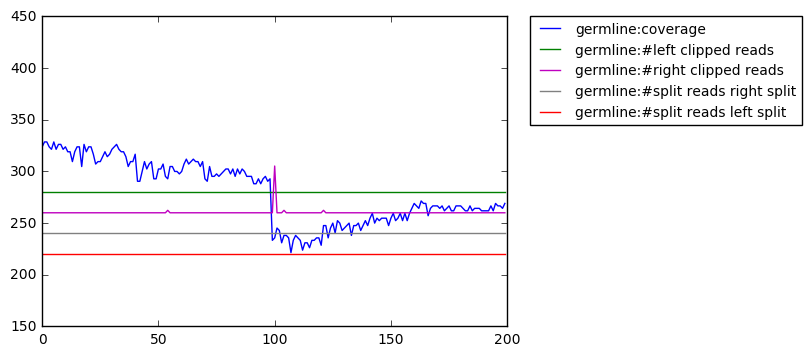

id: 3844
Nanopore: noSV . DeepSV: DEL_start


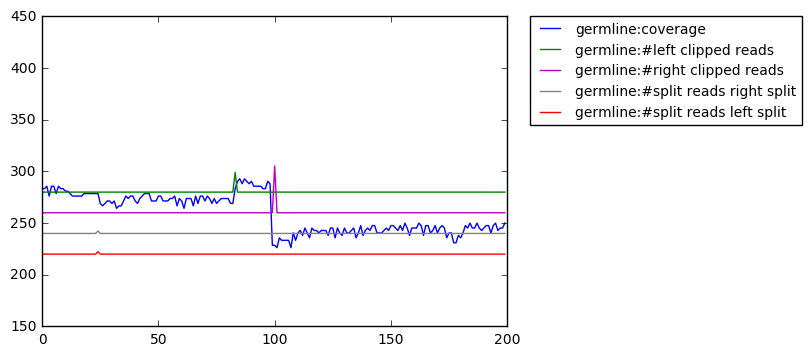

id: 3854
Nanopore: noSV . DeepSV: DEL_end


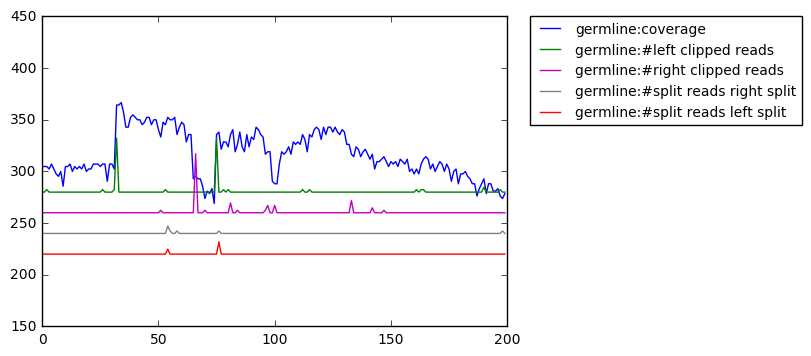

id: 3855
Nanopore: noSV . DeepSV: DEL_start


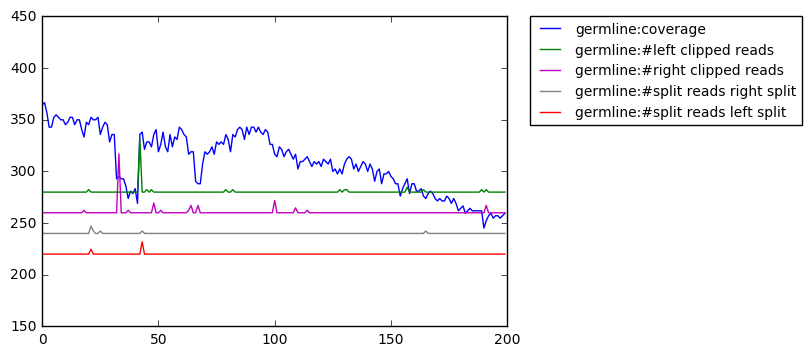

id: 3856
Nanopore: noSV . DeepSV: DEL_end


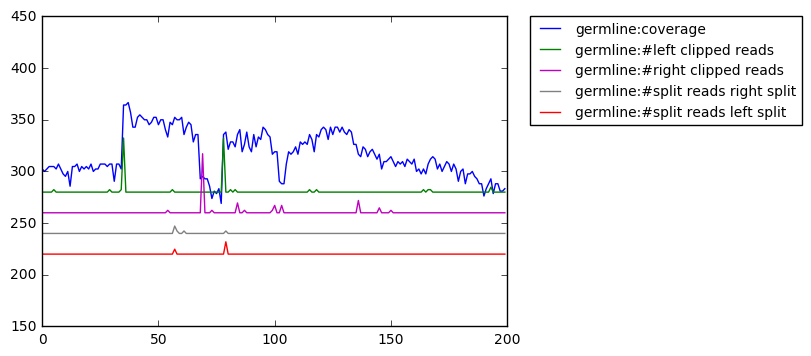

id: 3858
Nanopore: noSV . DeepSV: DEL_end


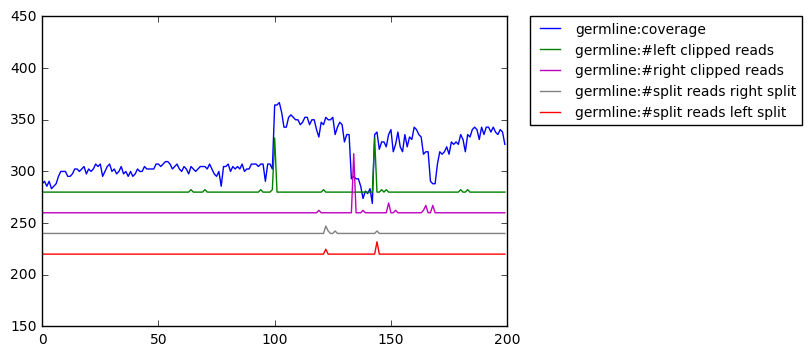

id: 3859
Nanopore: noSV . DeepSV: DEL_end


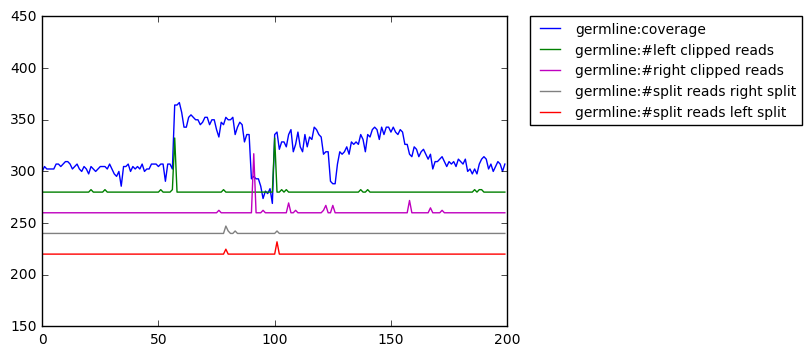

id: 3861
Nanopore: noSV . DeepSV: DEL_start


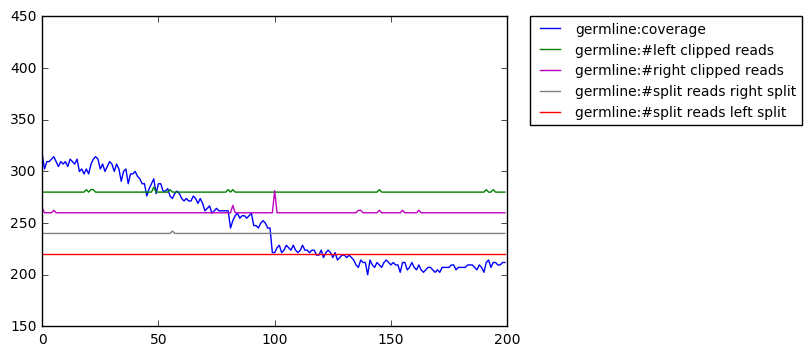

id: 3865
Nanopore: noSV . DeepSV: DEL_end


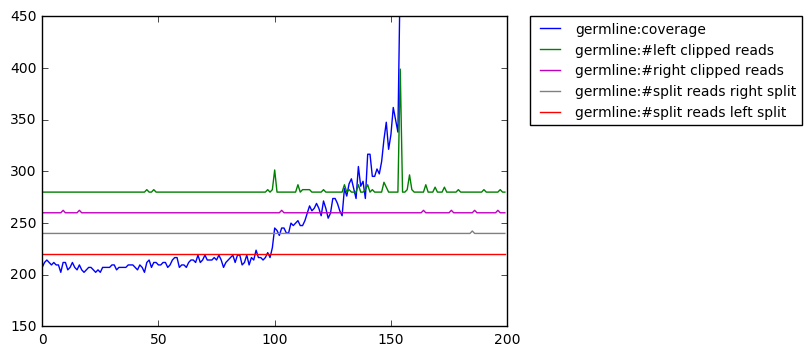

id: 3866
Nanopore: noSV . DeepSV: DEL_end


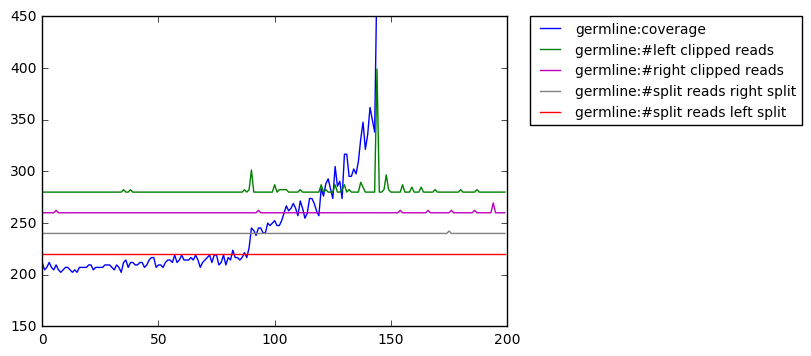

id: 3868
Nanopore: noSV . DeepSV: DEL_end


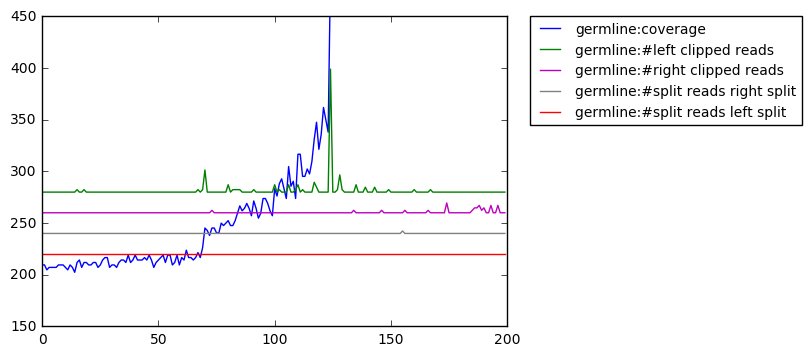

id: 3871
Nanopore: noSV . DeepSV: DEL_end


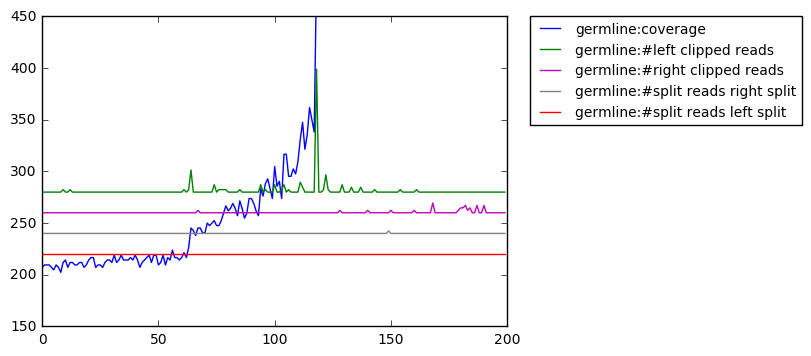

id: 3877
Nanopore: noSV . DeepSV: DEL_end


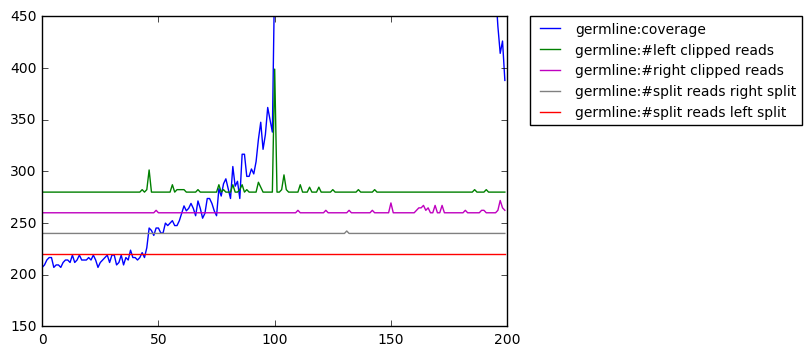

id: 3885
Nanopore: noSV . DeepSV: DEL_start


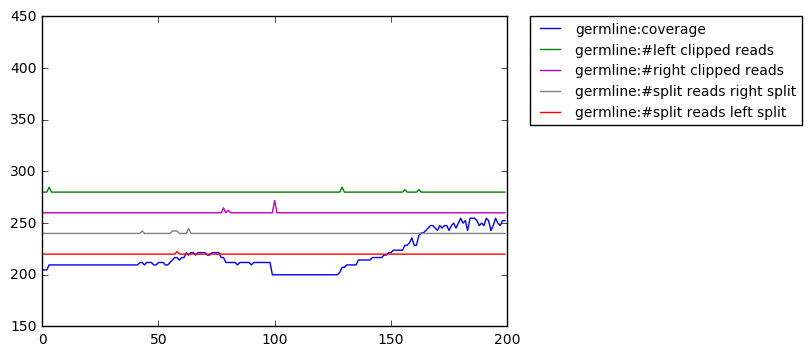

id: 3896
Nanopore: noSV . DeepSV: DEL_end


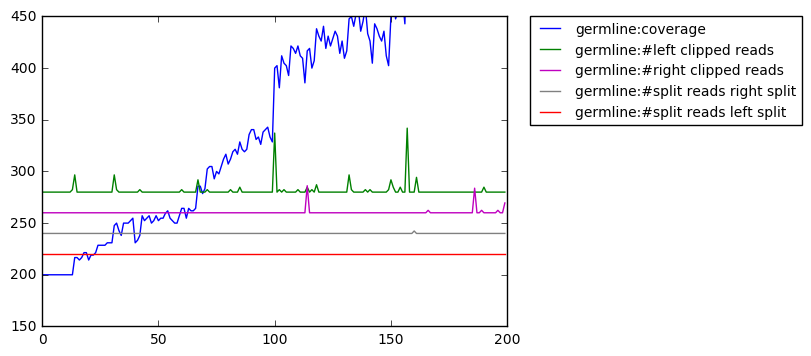

id: 3908
Nanopore: noSV . DeepSV: DEL_start


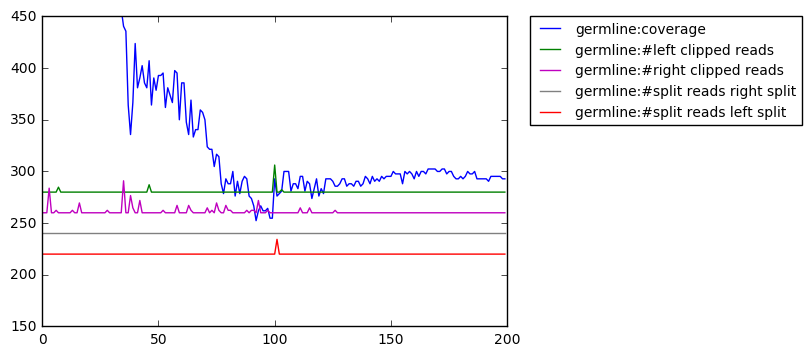

id: 3960
Nanopore: noSV . DeepSV: DEL_start


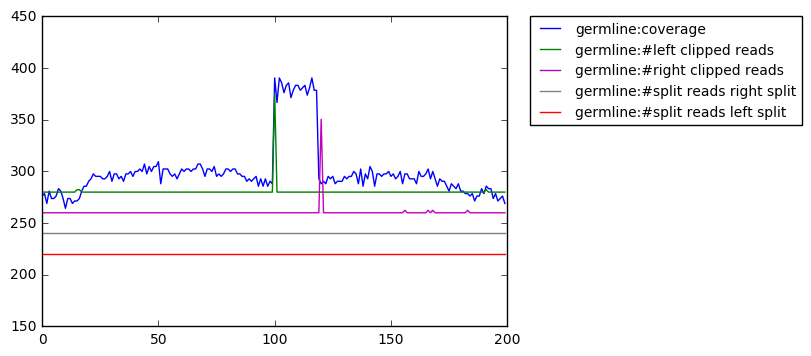

id: 3961
Nanopore: noSV . DeepSV: DEL_start


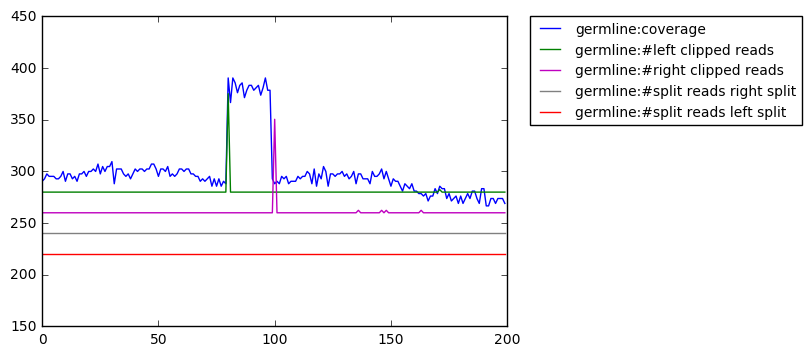

id: 3978
Nanopore: noSV . DeepSV: DEL_start


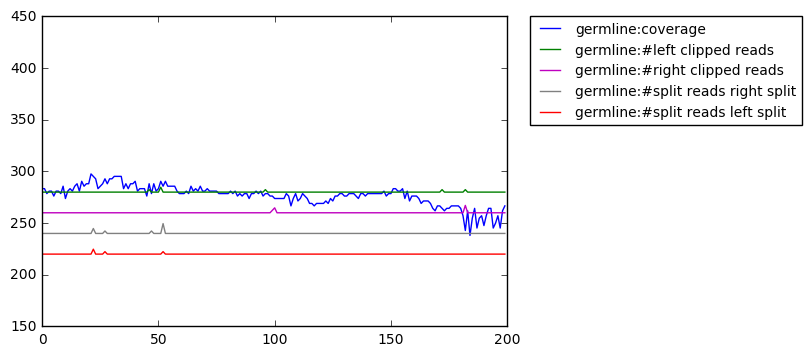

id: 3980
Nanopore: noSV . DeepSV: DEL_end


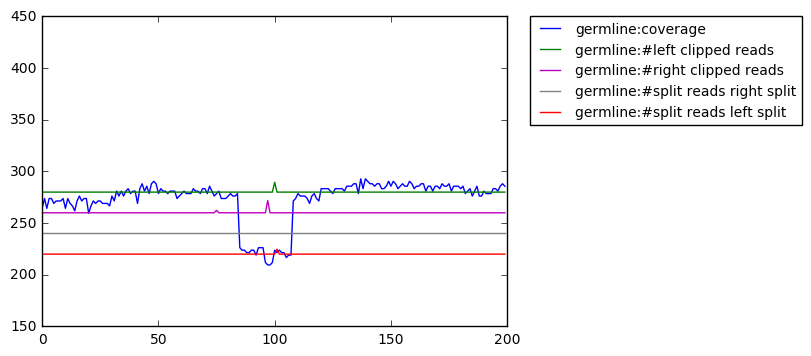

id: 4021
Nanopore: noSV . DeepSV: DEL_start


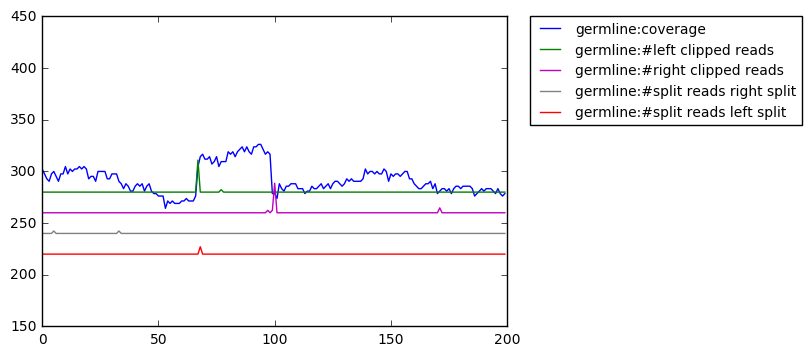

id: 4022
Nanopore: noSV . DeepSV: DEL_end


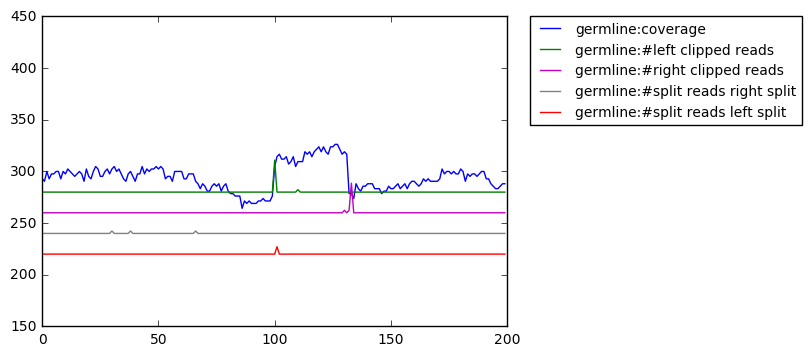

id: 4064
Nanopore: noSV . DeepSV: DEL_start


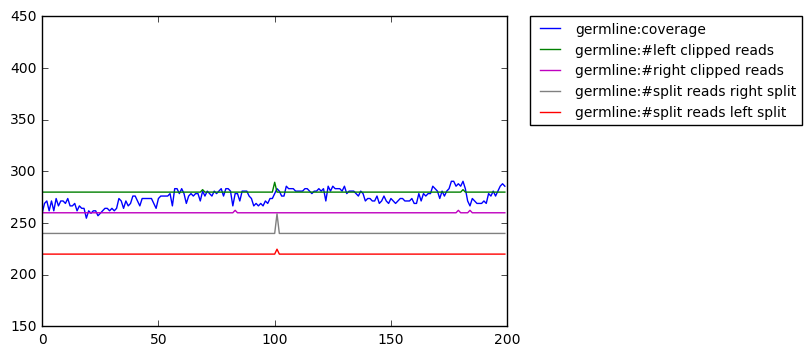

id: 4099
Nanopore: noSV . DeepSV: DEL_end


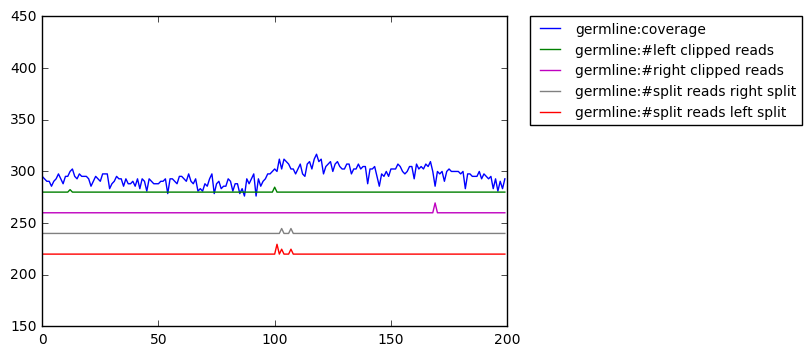

id: 4149
Nanopore: noSV . DeepSV: DEL_start


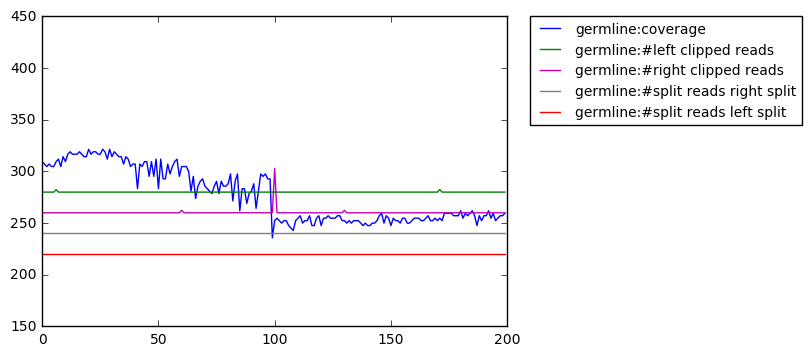

id: 4156
Nanopore: noSV . DeepSV: DEL_end


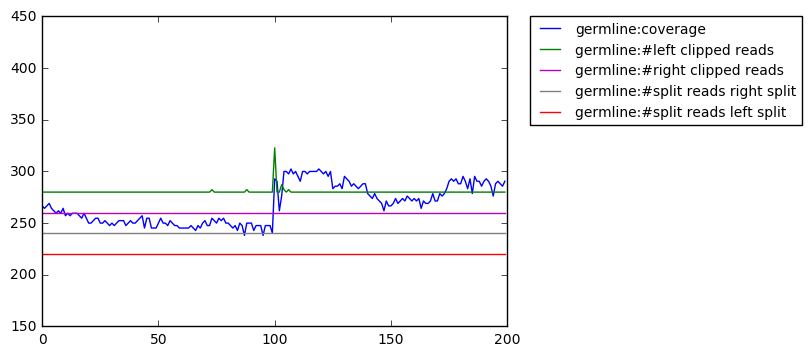

In [76]:
start_window = 0
n_windows = 5000
plot_channels(start_window, n_windows)

id: 10501
Nanopore: noSV . DeepSV: DEL_end


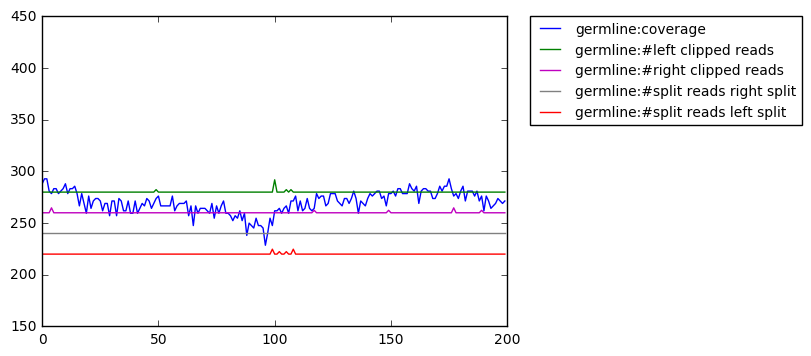

id: 10552
Nanopore: noSV . DeepSV: DEL_start


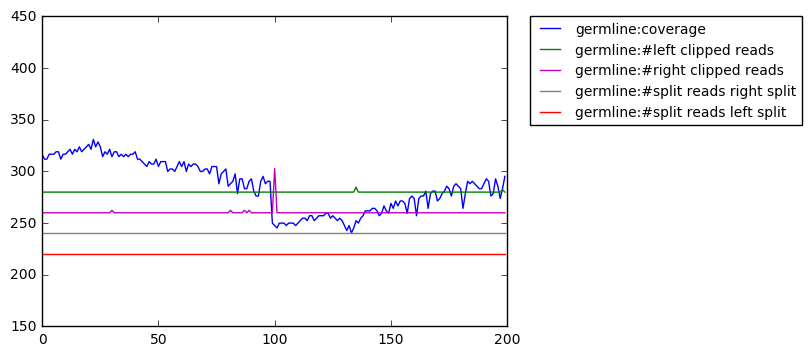

id: 10567
Nanopore: noSV . DeepSV: DEL_start


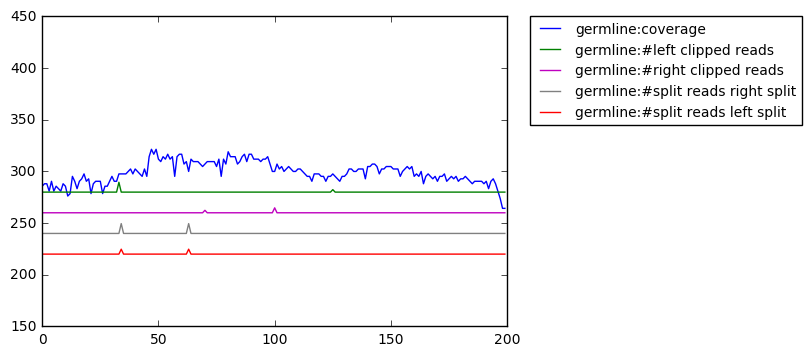

id: 10598
Nanopore: noSV . DeepSV: DEL_start


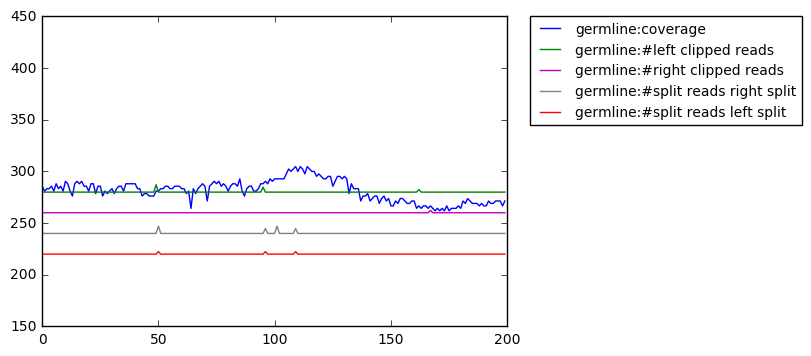

id: 10654
Nanopore: noSV . DeepSV: DEL_end


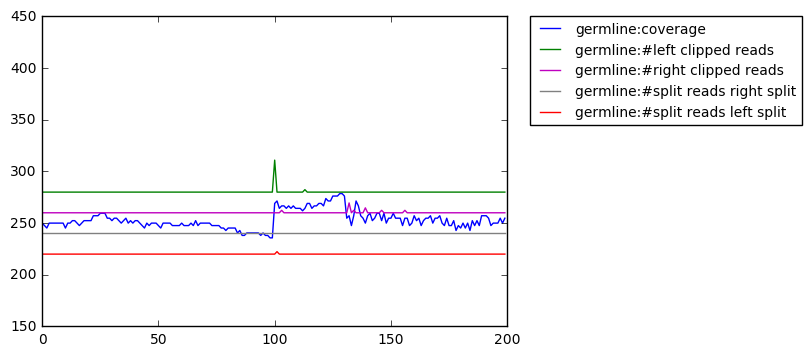

id: 10701
Nanopore: noSV . DeepSV: DEL_start


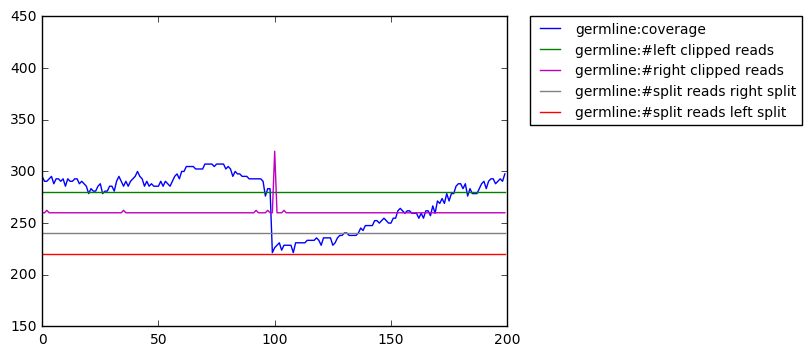

id: 10752
Nanopore: noSV . DeepSV: DEL_end


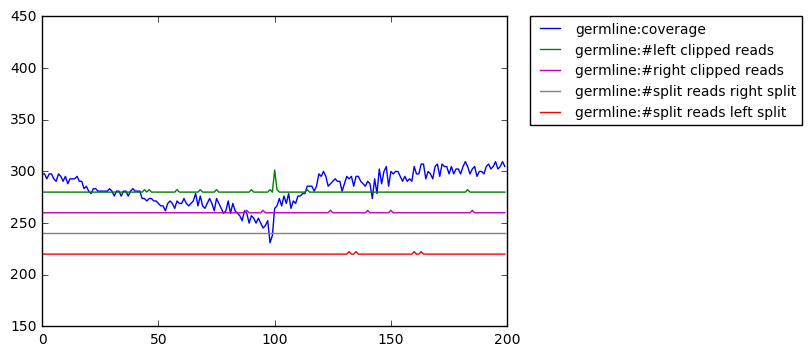

id: 10765
Nanopore: noSV . DeepSV: DEL_start


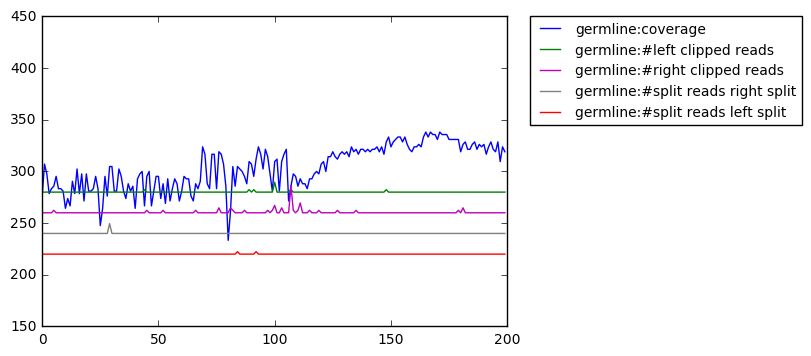

id: 10766
Nanopore: noSV . DeepSV: DEL_start


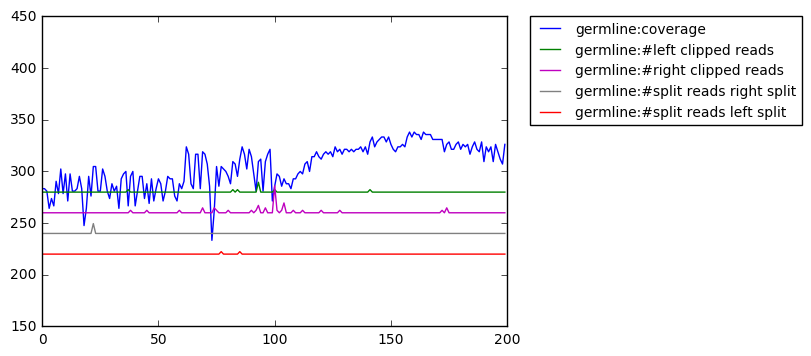

id: 10767
Nanopore: noSV . DeepSV: DEL_start


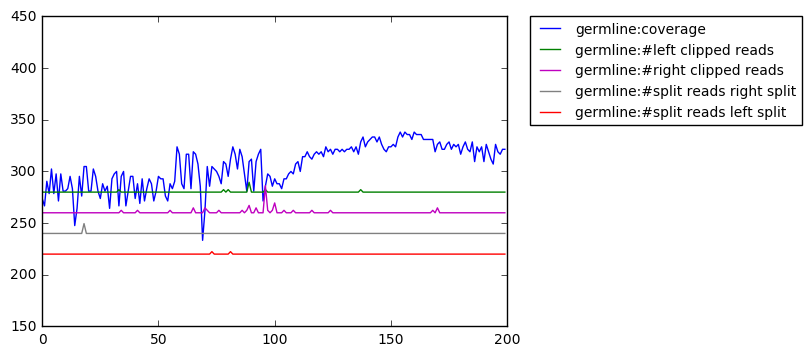

id: 11007
Nanopore: noSV . DeepSV: DEL_end


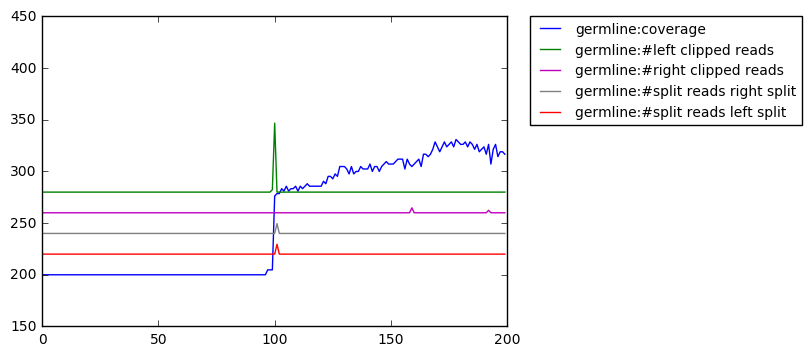

id: 11014
Nanopore: noSV . DeepSV: DEL_start


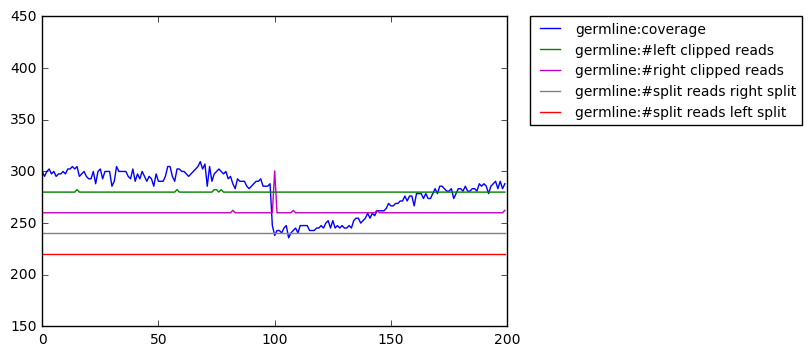

id: 11041
Nanopore: noSV . DeepSV: DEL_start


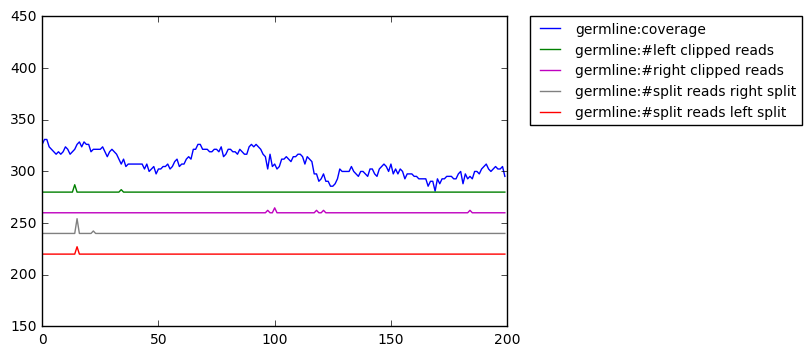

id: 11058
Nanopore: noSV . DeepSV: DEL_start


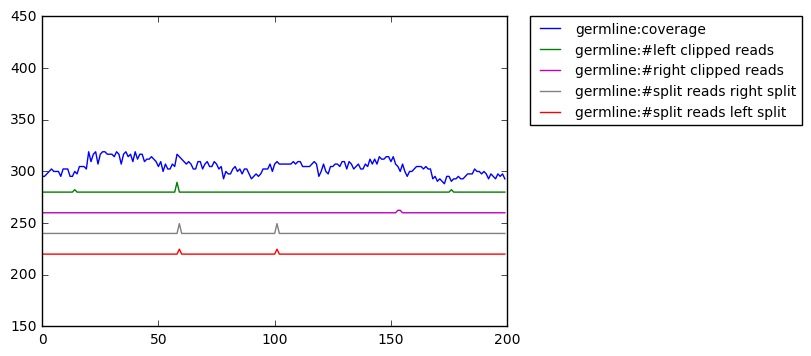

id: 11115
Nanopore: noSV . DeepSV: DEL_start


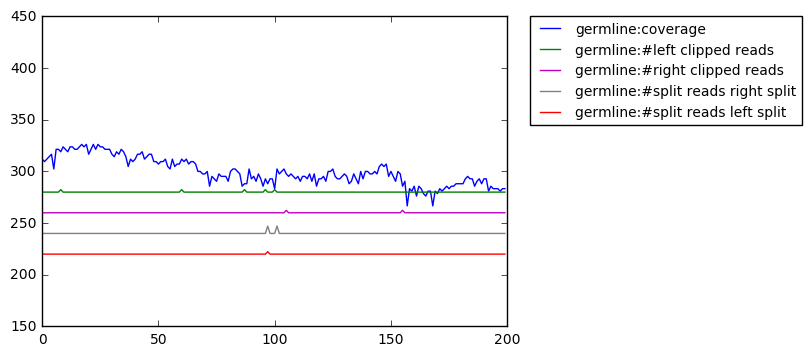

id: 11130
Nanopore: noSV . DeepSV: DEL_start


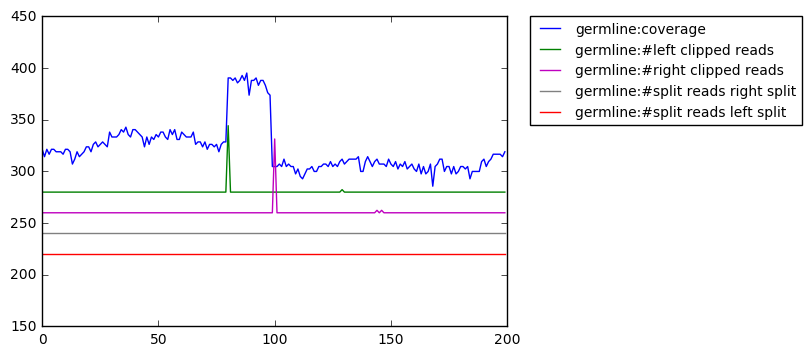

id: 11172
Nanopore: noSV . DeepSV: DEL_end


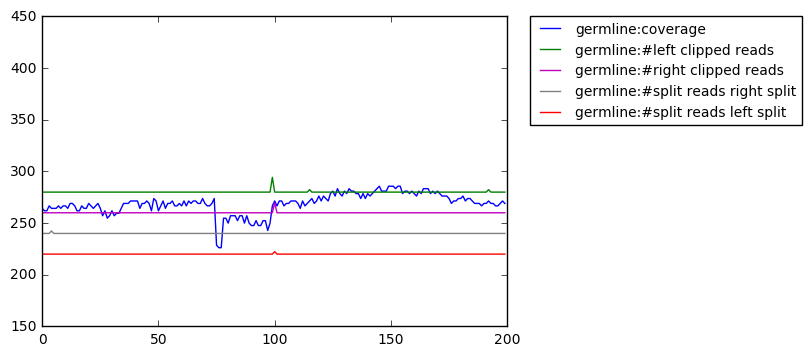

id: 11173
Nanopore: noSV . DeepSV: DEL_end


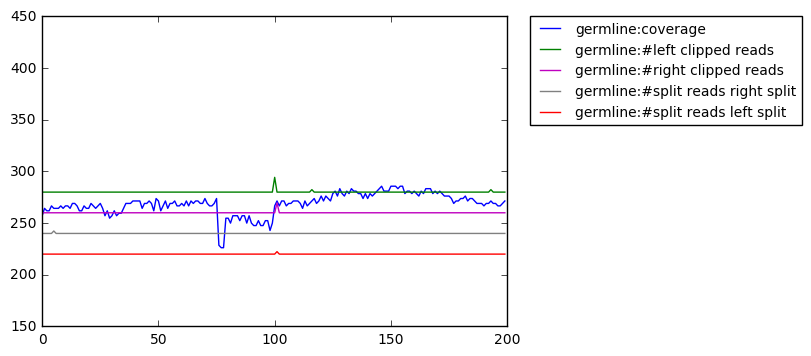

id: 11238
Nanopore: noSV . DeepSV: DEL_start


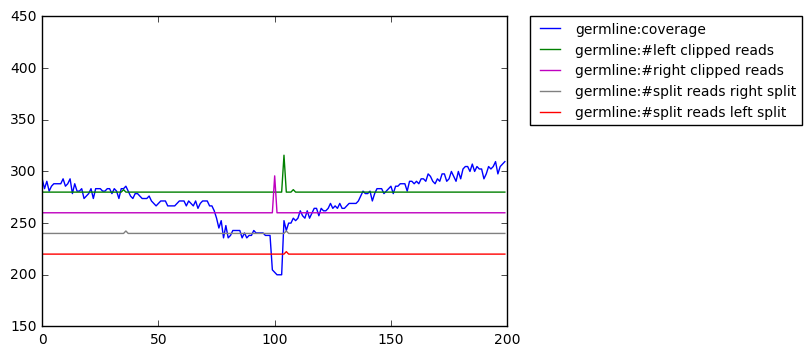

id: 11276
Nanopore: noSV . DeepSV: DEL_end


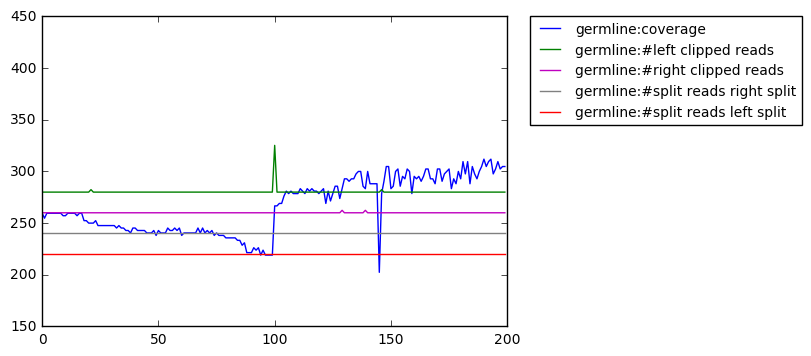

id: 11315
Nanopore: noSV . DeepSV: DEL_start


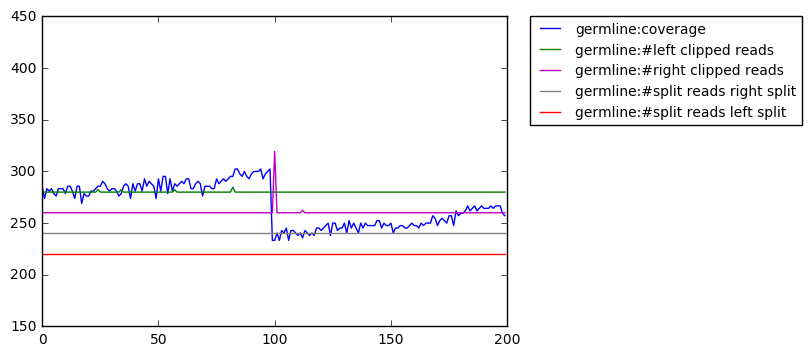

id: 11359
Nanopore: noSV . DeepSV: DEL_end


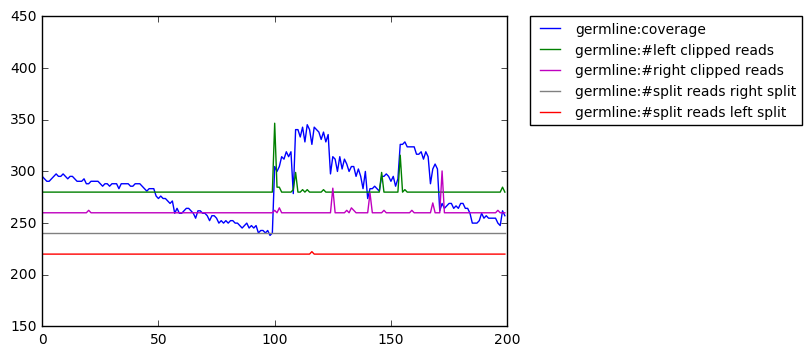

id: 11363
Nanopore: noSV . DeepSV: DEL_end


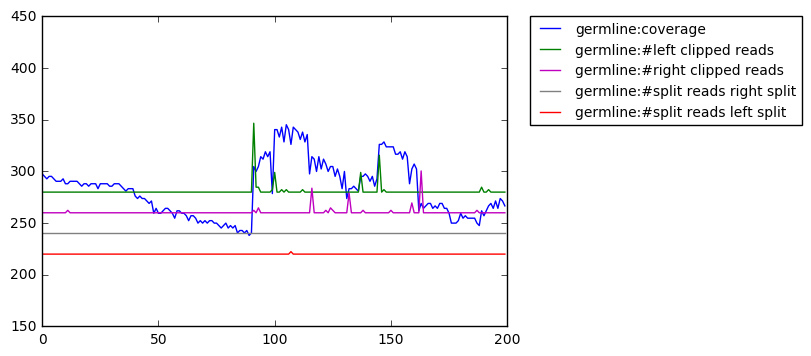

id: 11366
Nanopore: noSV . DeepSV: DEL_end


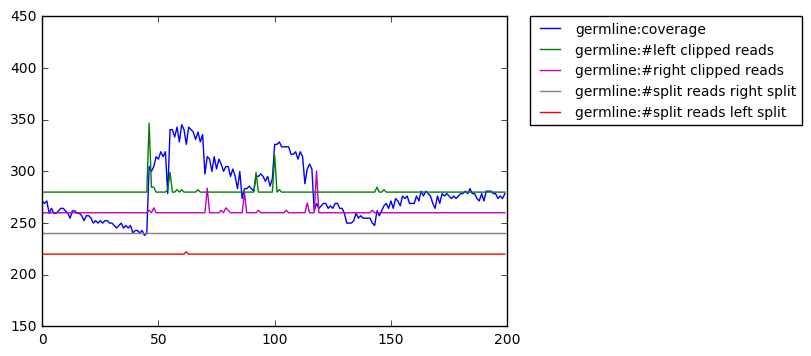

id: 11402
Nanopore: noSV . DeepSV: DEL_start


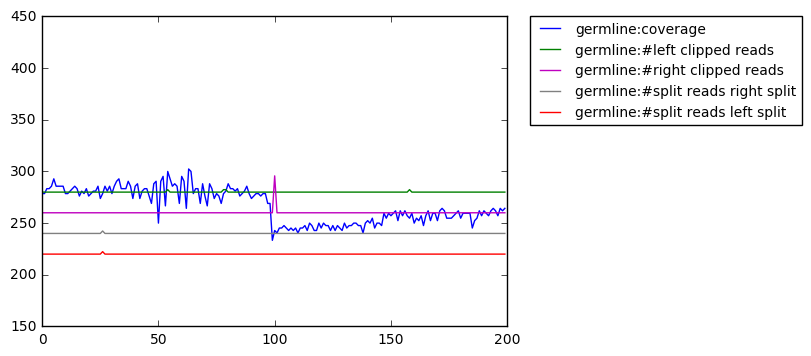

id: 11421
Nanopore: noSV . DeepSV: DEL_start


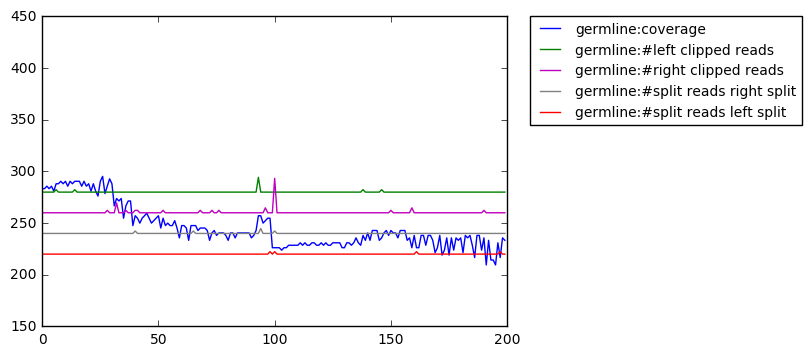

id: 11453
Nanopore: noSV . DeepSV: DEL_start


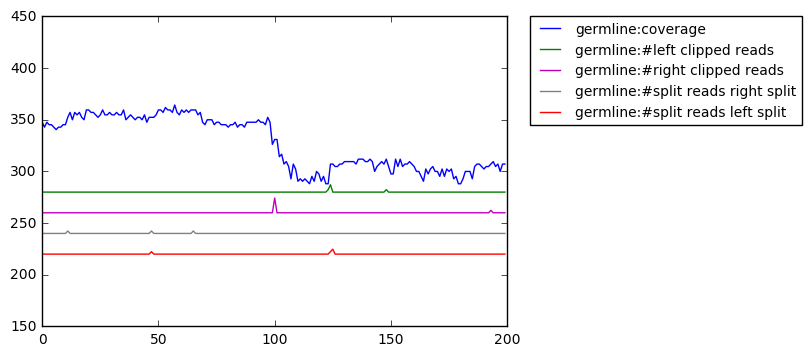

id: 11454
Nanopore: noSV . DeepSV: DEL_start


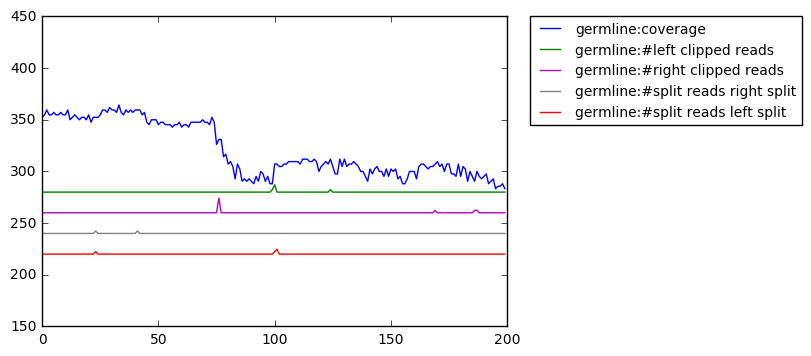

id: 11487
Nanopore: noSV . DeepSV: DEL_end


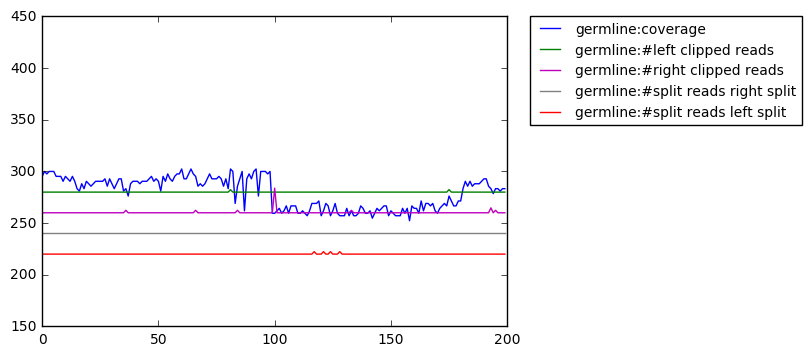

In [75]:
n_windows = 1000
start_window = 10500
plot_channels(start_window, n_windows)

   
## Transposes every window in X, to comply to McFly format

In [64]:
def transposeDataset(X):
    image = []
    for i in range (0, len(X -1)):
        tr = X[i].transpose()
        image.append(tr)
    return np.array(image)

image1 = transposeDataset(X_train)
image2 = transposeDataset(X_val)
image3 = transposeDataset(X_test)
X_train = image1
X_val = image2
X_test = image3

n_channels = len(X_test[0][0])
print(len(X_test[0][0]))

200


## Prepare the labels in McFly format

In [49]:
mapclasses = {'DEL_start': 1, 'DEL_end': 0,  'noSV': 2}
print(mapclasses)

{'DEL_end': 0, 'DEL_start': 1, 'noSV': 2}


In [50]:
#y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
#y_val = np.array([mapclasses[c] for c in y_val], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
#y_train_binary = to_categorical(y_train)
#y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

In [51]:
y_test_binary

array([[ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

In [52]:
X_train.shape

(0,)

## Reload the trained model

In [53]:
import os
from keras.models import load_model
model_path = os.path.join('F:/CNN/notebooks/',  'Gtcg_26_10_16xoversample_NoDiff_9749')
model_reloaded = load_model(model_path)

## Inspect model predictions on test data

In [54]:

model = model_reloaded 
datasize = X_test.shape[0]
probs = model.predict_proba(X_test[:datasize,:,:],batch_size=1)

## Columns are predicted labels by DeepSV, rows are nanopore labels

In [55]:
mapclasses = {'DEL_end': 0, 'DEL_start': 1, 'noSV': 2}
dict=mapclasses
dict_sorted = sorted(dict.items(), key=lambda x: x[1])
dict_sorted

[('DEL_end', 0), ('DEL_start', 1), ('noSV', 2)]

In [56]:
labels = [i[0] for i in dict_sorted]

In [57]:
import pandas as pd
predicted = probs.argmax(axis=1)
y_index = y_test_binary.argmax(axis=1)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [labels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [labels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in labels], fill_value=0)
confusion_matrix

DEL_end  DEL_start    noSV
DEL_end       1148          6      14
DEL_start        2       1292      16
noSV          2920       5055  192025

## Test best current model on testset

### Overall accuracy on the test set:

In [58]:
%%time
score_test = model.evaluate(X_test, y_test_binary, verbose=False)
print('Test loss and accuracy of best model: ' + str(score_test))

Test loss and accuracy of best model: [0.34812044779366219, 0.96042533015932596]
Wall time: 46.1 s


In [59]:
#9659 best test results : 9513

In [60]:
4000/25


160.0

In [ ]:
 print('Nanopore:', labels[y_test[i]], '. DeepSV:', labels[predicted[i]])

In [85]:
G1_data_noSV_confused = X_test[np.where(y_test == 2)]

In [86]:
G1_labels_noSV_confused = y_test[np.where(y_test == 2)]

In [87]:
predicted_confused = predicted[np.where(y_test == 2)]

In [88]:
G1_data_noSV_confused = G1_data_noSV_confused[np.where(predicted_confused != 2)]

In [89]:
G1_labels_noSV_confused = G1_labels_noSV_confused[np.where(predicted_confused != 2)]

In [90]:
predicted_confused = predicted_confused[np.where(predicted_confused != 2)]

In [91]:
G1_data_noSV_confused.shape

(7975, 5, 200)

In [92]:
G1_labels_noSV_confused.shape

(7975,)

In [93]:
predicted_confused.shape 

(7975,)

In [94]:
np.save(germline_1_datapath + "G1_data_noSV_confused.npy", G1_data_noSV_confused)

In [95]:
np.save(ger_1_labels_datapath + "G1_labels_noSV_confused.npy", G1_labels_noSV_confused)